# Bayesian Logistic Regression avec une prior de Laplace

In [108]:
#from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')



In [ ]:
%%javascript
// little fix to enumerate equations in markdown
// from https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/equation-numbering

MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from tqdm import tqdm
from scipy.linalg import eigvals
from scipy.stats import laplace
from scipy.stats import multivariate_normal
from scipy.special import expit 
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

Dans ce notebook, nous appliquons la **Stochastic Gradient Langevin Dynamic** afin d'effectuer une **Bayesian Logistic Regression** avec une **prior de Laplace** de scale $b=1$. Nous comparons également la Stochastic Gradient Langevin Dynamics à d'autres méthodes d'échantillonnage afin de tester son efficacité et notamment sa rapidité. Ce notebook se base sur l'article : Bayesian Learning via Stochastic Gradient Langevin Dynamics [[Welling, Teh 2011]](http://www.stats.ox.ac.uk/~teh/research/compstats/WelTeh2011a.pdf).

Ce **notebook** est volontairement très **détaillé** et nous y reprenons la plupart des idées importantes liées à la Stochastic Gradient Langevin Dynamic. Les notebook suivants, ie ``bayesian_nn.ipynb``et ``bayesian_linreg.ipynb``, seront plus succincts. 

On rappelle le modèle de la Bayesian Logistic Regression:

- On note $D = \{(x_1, y_1), ..., (x_N, y_N)\}$ le jeu de données et $\beta$ le paramètre,

- $p(\beta) \sim \mathcal{L}(0, 1)$ i.e $p(\beta) \propto \exp(-\|\beta\|_1)$,

- $ \forall i \in \{1, ..., N\}, y_i \sim \mathcal{B}\left(\sigma(\beta^{\top}x_i)\right)$ i.i.d, où $\sigma$ est la fonction sigmoïde. En utilisant la propriété $\forall z \in \mathbb{R}, \sigma(-z) = 1 - \sigma(z)$ on peut écrire: $\forall i \in \{1, ..., N\}, p(y_i | \beta, x_i) = \sigma(y_i \cdot \beta^{\top}x_i)$.

On a alors $\log p(\beta | X, y) \propto_+  \sum_{i=1}^N \log \sigma(y_i \cdot \beta^{\top}x_i) - \| \beta \|_1$.

On peut alors écrire un sous-gradient de la log-posterior en utilisant le fait que: $\forall z \in \mathbb{R}, \sigma'(z) = (1 - \sigma(z)) \cdot \sigma(z)$ et qu'un sous-gradient de la log-prior est $\partial_{\beta} \log p(\beta) = - \mathrm{sign}(\beta)$: 
$ \partial_{\beta} \log p(\beta | X, y) = \sum_{i=1}^N y_i \cdot x_i \left( 1 - \sigma(y_i \cdot \beta^{\top}x_i) \right) - \mathrm{sign}(\beta)$.

## 1. Stochastic Gradient Langevin Dynamic

Cette méthode a pour but d'allier **optimisation** (SGD) et **échantillonnage** (Langevin) en **une seule et unique méthode** afin d'étendre les méthodes bayésiennes aux cas de grands datasets.   

Sa grande force (mais qui fait aussi sa faiblesse, nous y reviendrons...) est qu'elle permet à la façon d'une méthode de Robbins-Monro d'échantillonner sans avoir à effectuer un calcul à partir du dataset entier. La **SGLD** utilise les données  par **batch**, contrairement à la **majorité** des méthodes **MCMC** qui utilisent **tout le training set**.  

Par exemple, un symetric random walk nécéssite, à chaque itération, de calculer la probabilité d'acceptation du candidat, qui est un rapport de densité ($\alpha = \mathrm{min}(1, \pi(\theta_t) \, / \, \pi(\tilde{\theta}_t))$ où $\pi$ est notre loi cible, en l'occurence la posterior sur les paramètres dans le cadre bayésien). Ceci peut donc s'avérer extrêmement couteux lorsque le nombre de points dans le dataset est important. 

Dès lors que la phase d'**optimisation** est terminée, i.e que l'on se stabilise dans une zone de forte probabilité de la posterior (attention, pas necessairement dans un unique mode, l'idée est d'explorer des zones de forte probabilité autres que le mode donné par le MAP uniquement), l'algorithme **échantillonne** selon cette loi. Comme avec toute méthode MCMC, le théorème ergodique nous permet d'approximer des calculs d'éspérance et donc de **predictive distribution**.

### 1.1. Un bref récapitulatif de la méthode

#### 1.1.1. Une itération

En exploitant les calculs précédents, l'itération $t$ de la **SGLD** s'écrit:

- Selectionner un batch $B_t = \{x_{t_1}, ..., x_{t_n}\}$ et calculer la step-size $\epsilon_t = a \cdot (b+t)^{-\gamma}$

- Échantilloner $\eta_t \sim \mathcal{N}(0,\epsilon_t \cdot I)$

- Mettre à jour $\beta_{t+1} \leftarrow \beta_t + \frac{1}{2} \epsilon_t \cdot \left[ \frac{N}{n} \sum_{i=1}^n y_{t_i} \cdot x_{t_i} \left( 1 - \sigma(y_{t_i} \cdot \beta^{\top}x_{t_i}) \right) -  \mathrm{sign}(\beta)\right] + \eta_t$

Notons que $\gamma \in (0.5, 1)$ de sorte de que $\sum_{t=0}^{+\infty} \epsilon_t = +\infty$ et $\sum_{t=0}^{+\infty} \epsilon_t^2 < +\infty$.   
Cette condition, classique lorsque on effectue des approximations stochastiques, permet d'assure la convergence de la phase d'optimisation. Elle est liée à l'aspect Stochastic Gradient Descent et non à la dynamique de Langevin.

#### 1.1.2. Phase d'optimisation (SGD) et phase d'échantillonnage (Langevin)

Il peut être assez difficile d'estimer précisement le **début** de la phase d'**échantillonnage** sans avoir à calculer la posterior à chaque itération, ce qui ferait perdre à la méthode toute son utilité puisqu'on devrait calculer une quantité nécessitant le traitement du dataset entier. De plus, cette estimation est très importante dans la mesure où l'inclusion d'échantillons de la phase d'optimisation dans les **calculs d'éspérances** biaserait fortement ces derniers.

L'article fournit une méthode **empirique** d'estimation du début de la phase de sampling. On rappelle que l'on met à jour les échantillons, à chaque itération $t$, en ajoutant un terme $\Delta \theta$ à l'échantillon $\theta_t$ (c.f description d'une itération ci-dessus). Ce terme $\Delta \theta$ est composé d'un terme lié au gradient de la posterior sur un batch et d'un terme de bruit. On entre alors dans la phase d'échantillonnage lorsque le bruit dans $\Delta \theta_t$ domine dans toutes les directions. On peut alors exprimer cette condition via la covariance empirique des gradients sur le batch. Détaillons alors brièvement cette 

Conservons les notations précédentes et supposons que l'on travaille, à l'**itération** $t$, sur le **batch** $B_t = \{x_{t_1}, ..., x_{t_n}\}$. On note alors les "**scores**" $s_{t_i} = \nabla \log p(x_{t_i}| \theta_t) + \frac{1}{N} \nabla \log p(\theta_t)$ et $V_s = \frac{1}{n} \sum_{i=1}^n (s_{t_i} - \bar{s_{t_i}}) (s_{t_i} - \bar{s_{t_i}})^{\top}$ leur covariance empirique. Lorsque $t$ est assez grand, par le théorème central limite, les **variations** du terme de **gradient** dans $\Delta \theta_t$ seront **normalement distribuées**, de variance $\frac{N^2}{4n} V_s$. Ainsi, en notant $\lambda_{max}$ l'opérateur associant à une matrice sa valeur propre maximale, on peut exprimer la **domination du bruit** dans **toutes les directions** par la condition:
$$
\alpha_t = \epsilon_t \frac{N^2}{4n} \lambda_{max}(V_s) \ll 1
$$
Notons que dans l'article, ces calculs sont présentés avec multiplication des données par une **matrice de conditionnement** $M$ (pensez par exemple à la standardisation des données, pour mettre toutes les dimesnions à la même échelle). Par la formule de la chaîne, multiplier les données par cette matrice revient à multiplier le gradient par cette même matrice et les calculs s'adaptent alors aisément.

Dans nos expériences numériques, nous calculerons les $(\alpha_t)_{t\geq 0}$ afin de visualiser leur décroissance jusqu'à l'entrée en phase d'échantillonnage. 

#### 1.1.3. Distribution prédictive

En utilisant les échantillons fournis par l'algorithme et en fixant un seuil $t_0$ (burn-in) à partir duquel on suppose être dans la phase d'échantillonnage (i.e en supposant que $(\beta_t)_{t\in\{t_0, ..., T\}}$ sont distribués selon la posterior, on peut approximer la **distribution predictive** du label $y^*$ d'un **nouvel échantillon** $x^*$ par **Monte Carlo**: $p(y^* | x^*, X, y) = \mathbb{E}_{p(\beta|X,y)}\left[\, p(y^*|\beta,x^*)\, \right] \approx \frac{1}{T-t_0} \sum_{i=t_0}^T p(y^*|\beta_t, x^*)$.  

On obtient alors, pour $x^*$ un nouvel échantillon: $p(y^*=1|x^*, X, y) \approx \frac{1}{T-t_0} \sum_{t=t_0}^T \sigma(\beta_t^{\top} x^*)$. 

De plus, il est interessant de préciser que l'article suppose une autre façon de calculer des espérances selon la posterior en utilisant les step-sizes calulées à chaque itération et approximer: $\mathbb{E}_{p(\beta|X,y)}\left[p(y^*|\beta,x^*)\, \right] \approx \frac{1}{T-t_0} \sum_{t=t_0}^T  \epsilon_t \, p(y^*|\beta_t, x^*) \, \, / \, \sum_{t=t_0}^T \epsilon_t$.  

L'idée est de contrer le fait que les step-sizes $\epsilon_t {\rightarrow 0}$ quand $t \rightarrow \infty$, donc le **taux de mélange** de la chaîne de Markov diminue et les échantillons deviennent de **plus en plus corrélés** à mesure que l'on échantillonne. On **pondère** ainsi la contribution de chaque échantillon à l'approximation de l'espérance en fonction de la step-size correspondante. Comme $\sum_{t} \epsilon_t = \infty$, cet estimateur de l'éspérance est toujours consistant.

#### 1.1.4. Predictions et bénéfices des méthodes bayésiennes

Si l'on veut faire de la "hard-classification", on peut alors prédire $\hat{y}^* = \mathbb{1}_{\{p(y^*=1|x^*, X, y) \geq p_0\}}$ où $p_0$ est une probabilité de seuil qui peut être optimisée selon les types de métriques que l'on veut optimiser (precision, recall, accuracy...). Toutefois, l'intérêt majeur de cette méthode est qu'elle permet d'estimer **l'incertitude** et donc la **robustesse** de notre **prédiction**, ce qui est fondamental dans de nombreux domaines (médical, contrôle...). 

Il est vrai qu'une **logistic regression classique** fournit, par le biais de la likelihood de Bernoulli, une estimation de la probabilité de la classe d'un nouvel échantillon sachant le paramètre: $p(y^* | x^*, \hat{w}) = \sigma(x^{* \top} \hat{w})$ où $\hat{w}$ peut être l'estimateur MAP ou ML du paramètre.  

En revanche, il a été montré dans cet article: On calibration of modern neural networks [[Guo et al., 2017]](https://arxiv.org/pdf/1706.04599.pdf), que ce type de classifieurs est **sur-confiant**. Cet article traite de réseaux de neurones mais la logistic regression est un cas particulier simple de réseau de neurone utilisant des couches finales de type sigmoïde (ou softmax si la classification est multi-classe). Par exemple, s'ils prédisent $p(y^* = 1 | x^*, \hat{w}) = 0.9$, cette prédicion ne s'avère pas vraie dans 90% des cas, comme ce qui serait suggéré par cette probabilité. En revanche, les **méthodes bayésiennes** fournissent par le biais de la distribution predictive une **estimation** bien plus **efficace** de l'**incertitude** sur la prédiction.

#### 1.1.5. Une précision sur l'évalution des exécutions de l'algorithme

Enfin, précisons que pour toute la suite, afin de pouvoir effectuer des comparaisons pertinentes, **nous exécuterons toujours** la **SGLD deux fois** en réinjectant le **dernier échantillon** de la **premier éxécution** en **échantillon initial** de la **deuxième éxécution**. Les **échantillons** analysés et utilisés pour des **prédictions** seront alors les échantillons issus de la **seconde éxécution**.

### 1.2. Implementation

In [2]:
def get_step_size(a, b, gamma, t):
    """
    Get the step size for parameters (a, b, gamma) at iteration t.
    Arguments:
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      t: int, iteration number
    Return:
      float, step_size
    """
    return a * (b + t) ** (- gamma)

def post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) posterior over the whole training set in beta.
    For numerical stability, prefer np.exp(log_post_laplace(beta, X, y)) to compute posterior pdf.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels 
    Return:
      float, (unormalized) posterior evaluated in beta
    """
    return np.product(expit(y * (X @ beta))) * np.exp(- np.linalg.norm(beta, ord=1))

def log_post_laplace(beta, X, y):
    """
    Evaluate the (unormalized) log-posterior pdf over the whole training set in beta.
    Arguments:
      beta: np.array, parameter of logistic regression
      X: np.array,  training examples 
      y: np.array, training labels 
    Return:
      float, (unormalized) log-posterior evaluated in beta
    """
    return (np.log(expit(y * (X @ beta)))).sum(axis=0) - np.linalg.norm(beta, ord=1)

def gradient_laplace(beta, batch_X, batch_y, n_samples, bool_cov_score=False):
    """
    Get a sub-gradient of the log-posterior pdf w.r.t beta for a given batch.
    Arguments:
      beta: np.array, parameter of logistic regression
      batch_X: np.array, batch of training examples 
      y: np.array, labels of training examples in the batch
      n_samples, int, number of samples in the training set
      bool_cov_score: boolean, if True compute the covariance of the score (to estimate the beginning of the sampling phase)
    Return:
      batch_grad: np.array, sub-gradient of the log-posterior w.r.t beta for the given batch
      cov_score: np.array, empirical covariance of the score (score = partial gradient for each sample in the batch + 1/n_samples sub-gradient of the prior)
    """
    # get batch gradient 
    res = (expit(- batch_y * (batch_X @ beta)) * batch_y)[:, None] * batch_X
    batch_grad = (n_samples / len(batch_X)) * res.sum(axis=0) - np.sign(beta)
    if bool_cov_score==False:
        return batch_grad
    
    # get empirical covariance of the score if required
    else:
        # get score 
        res2 = res - (1/n_samples) * np.sign(beta)
        # get empirical covariance
        cov_score = (1 / len(batch_X)) * (res2 - res2.mean(0)).T @ (res2 - res2.mean(0))
        return batch_grad, cov_score 

def SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackW=False, bool_trackL=False, bool_trackA=False):
    """
    SGLD for Bayesian Logistic Regression with Laplace Prior.
    Arguments:
      X: np.array,  training examples 
      y: np.array, training labels
      n_iter: int, number of iterations
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta 
      batch_size: int, size of the batch 
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
      bool_trackA: boolean, if True compute and return the alpha to evaluate begining of the sampling phase (see article for expression)
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
    """
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    betas = np.concatenate((beta[None, :], np.zeros((n_iter, dim))), axis=0)
    
    # compute and store log-posterior throughout the iterations if required
    if bool_trackL: 
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))
        
    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)
    
    # store weights throughout the iterations if required
    if bool_trackA:
        trackA = np.zeros(n_iter)
    
    for ii in tqdm(range(n_iter)):
                
        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]
        
        ### STEP 1: ###
        # compute step size 
        step_size = get_step_size(a, b, gamma, t=ii)
        
        ### STEP 2: ###
        # sample noise
        eta = multivariate_normal.rvs(mean=np.zeros(dim), cov=step_size*np.eye(dim))
        
        ### STEP 3: ###
        # update and store parameter
        if bool_trackA:
            grad, cov_score = gradient_laplace(beta, batch_X, batch_y, n_samples=N, bool_cov_score=True)
        else:
            grad = gradient_laplace(beta, batch_X, batch_y, n_samples=N)
        beta = beta + (step_size / 2) * grad + eta 
        betas[ii+1] = beta
        
        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)
            
        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size
            
        # compute and store alpha if required
        if bool_trackA:
            trackA[ii] = ((step_size * N**2) / (4 * len(batch_X))) * np.amax(np.real(eigvals(cov_score)))
            
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    if bool_trackA & bool_trackW & bool_trackL:
        return betas,trackA, trackW, trackL
    if bool_trackA & bool_trackW: 
        return betas, trackA, trackW
    if bool_trackA & bool_trackL: 
        return betas, trackA, trackL
    if bool_trackW & bool_trackW: 
        return betas, trackW, trackL
    if bool_trackA:
        return betas, trackA 
    if bool_trackW:
        return betas, trackW
    if bool_trackL:
        return betas, trackL
    else:
        return betas
    
def predictive_MC(X_new, samples, burn_in=None, weights=None):
    """
    Get the predictive distribution by Monte-Carlo approximation.
    Arguments:
      X_new: np.array, new unseen examples
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
      weights: np.array, weights to compute expectation (if None: uniform weights)
    Return:
      np.array, predictive distribution
    """
    if burn_in==None:
        burn_in=1
    if np.all(weights)==None:
        return expit(X_new @ samples[burn_in+1:].T).mean(1) 
    else:
        return (weights[None, burn_in:] * expit(X_new @ samples[burn_in+1:].T)).sum(1) / weights[burn_in:].sum()
    
def get_acc_iter(X, y, samples, burn_in=None):
    """
    Get the accuracy (training or testing) given by the sample at each iteration.
    Arguments:
      X: np.array, training or testing examples
      y: np.array,  training or testing labels
      samples: np.array,  samples from the posterior (size = n_samples x dim)
      burn_in: int, threshold to get actual sample from the posterior (time for the markov reach to reach its stationnary distribution)
    Return:
      np.array, accuracy (training or testing) at each iteration
    """
    if burn_in==None:
        burn_in=1
    return 100 * (np.sign(X @ samples[burn_in:].T) == y[:, None]).mean(0)

def get_criterion_ent(pred_distrib, idxs_misclass):
    """
    Get the accuracy (training or testing) given by the sample at each iteration.
    Arguments:
      pred_distrib: np.array, predictive distribution
      idxs_misclass: np.array,  indexes of misclassified training examples
    Return:
      np.float, criterion to measure uncertainty management
    """
    prob_misclass = pred_distrib[idxs_misclass]
    return - (prob_misclass * np.log2(prob_misclass) + (1-prob_misclass) * np.log2(1-prob_misclass)).mean()

### 1.3. Application sur des données synthétiques (linéairement séparables) 

Dans cette section, on teste notre implémentation de la SGLD sur un dataset **linéairement séparable** dans $\mathbb{R}^2$.  

Notons qu'afin d'avoir une posterior $p(\beta | X, y)$ facilement visualisable par l'affichage de ses courbes de sous-niveaux, on considère un dataset linéairement séparable dont un hyperplan séparateur passe par l'origine $(0, 0)$. Nous n'avons alors pas à inclure de biais et donc la posterior est définie sur $\mathbb{R}^2$. 

**Note:**  
Cette section est **assez détaillée**, puisqu'elle nous permet de fixer et de décrire les expériences numériques réalisées. Par la **suite**, comme nous répèterons les même expériences mais avec de nouvelles méthodes d'échantillonnage, nous serons plus **succincts**. 

#### 1.3.1. Visualisation des données

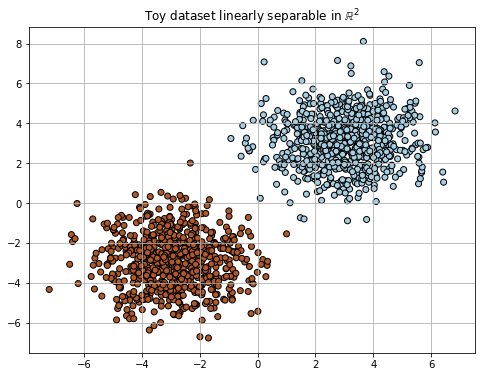

In [3]:
# load linearly separable dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

#### 1.3.2 Temps d'éxécution

Examinons brièvement le temps de calcul pour générer $N=5000$ échantillons pour ce dataset simple.

On rappelle que le but de la SGLD est de traiter les données par **batch**, mais elle nécessite tout de même une phase de **calibration** des **hyper-paramètres** afin d'assurer une convergence efficace. Pour cette calibration, nous devons calculer les **log-posterior** $\left(\log p(\beta_t | X, y)\right)_{t\geq 0}$ et les **coeffcients** $(\alpha_t)_{t \geq 0}$ à chaque étape. Le calcul de ces quantités implique d'une part le traitement des données dans tout le dataset, et d'autre part un calcul de valeur propre d'une matrice symétrique de $\mathbb{R}^{|B|x|B|}$ ou $|B|$ est la taille du batch, elles sont donc couteûses. On analyse donc le temps d'éxécution **avec et sans** le calcul de ces quantités. 

Dans le cas où les poids sont stockés à chaque étape, ce sont uniquement des ``floats`` stockés dans un ``np.array`` de taille fixée, où l'allocation mémoire est déja pré-effectuée lors de l'initialisation `trackW = np.zeros(n_iter)`. Ce n'est donc absolument pas couteux. Il n'est donc pas nécessaire de s'intéresser au temps de calcul lorsque l'on stocke, en plus, les poids à chaque étape.

Précisons également que les **paramètres** $a, \, b, \, \gamma$ des step-sizes $(\epsilon_t)_{t \geq 0}\, =\, (a\cdot(b+t)^{-\gamma})_{t \geq 0}$ ont été calculées **empiriquement** afin d'assurer une convergence rapide sans être trop chaotique. Notamment, l'idée est d'avoir une convergence assez rapide lors de la phase d'optimisation, sans qu'elle soit trop chaotique. La SGLD est, en quelques sortes, un symmetric random walk où l'on accepte le candidat à chaque étape sans calculer la probabilité d'acceptation. Lorsque la step-size $\epsilon_t$ est faible, cet aspect ne pose pas de problème. En revanche, lorsque celle-ci est grande, i.e que nous sommes dans les premières itérations de l'algorithme, cela peut poser problème, surtout si la taille du batch est petite et donc que le gradient stochastique a une variance élevée. Cette étape de **calibration** des **hyper-paramètres** est donc **très importante** afin de conserver une **stabilité numérique** et d'**éviter de l'overflow** lors des calcul de gradients.

In [4]:
a = 1
b = 20
gamma = .6
batch_size = 5
beta_0 = np.random.rand(X.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing log-posterior at each step  
print(f"\nComputing just the log-posterior at each step:")
time.sleep(1)
betas, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing alphas at each step  
print(f"\nComputing just the alphas at each step:")
time.sleep(1)
betas, trackA = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing both alphas and log-posterior at each step  
print(f"\nComputing both the log-posterior and the alphas at each step:")
time.sleep(1)
betas, trackA, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:01<00:00, 4696.28it/s]


Done in 1.07 s.

Computing just the log-posterior at each step:


100%|██████████| 5000/5000 [00:01<00:00, 4471.38it/s]


Done in 1.12 s.

Computing just the alphas at each step:


100%|██████████| 5000/5000 [00:01<00:00, 4424.61it/s]


Done in 1.13 s.

Computing both the log-posterior and the alphas at each step:


100%|██████████| 5000/5000 [00:01<00:00, 3211.21it/s]


Done in 1.56 s.


#### 1.3.3. Quid de la convergence ?

In [5]:
a = .5
b = 30
gamma = .7
batch_size = 10
beta_0 = np.ones(X.shape[1])  # re-inject last sample in the next run
n_iter = 5000

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)

Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:01<00:00, 3193.88it/s]


Done in 1.57 s.


Vérifions alors que l'on optimise bien la log-posterior puis que l'on échantillonne selon la posterior. On devrait observer deux phases:

- une phase où la **log-posterior croît rapidement** (**phase d'optimisation**: SGD),

- une phase où l'algorithme se **stabilise dans une zone de forte probabilité de la posterior** distribution et échantillonne (**phase d'échantillonnage**: Langevin). Attention!! Préciion que le but n'est pas de stabiliser dans un unique mode de la posterior (comme le MAP) mais d'explorer les zones de forte probabilité, notamment dans le cas où la posterior serait multi-modale.

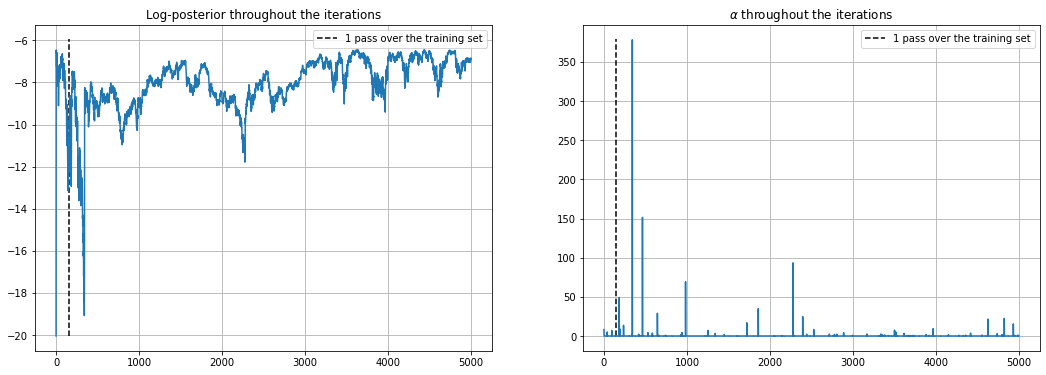

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

In [7]:
print(f"Averaged log-posterior over the last 1000 iterations: {round(trackL[-1000:].mean(), 2)}.")
print(f"Averaged alpha over the last 1000 iterations: {round(trackA[-1000:].mean(), 2)}.")

Averaged log-posterior over the last 1000 iterations: -6.99.
Averaged alpha over the last 1000 iterations: 0.08.


On observe donc qu'après **1 passage** sur le training set (batch_size=5, training_set_size=1000) et ces valeurs de $a$, $b$ et $\gamma$, on se **stabilise** plus ou moins dans la **phase d'échantillonage**.

Notons que l'on a calculé les coefficients $(\alpha_t)_{t \geq 0}$ **sans prendre en compte** de **matrice de conditionnement** $M$. Ces coefficients restent toutefois **très faibles**, et on a la moyenne empirique empirique sur les 1000 derniers échantillons $\frac{1}{1000}\sum_{t=T-1000}^T\alpha_t \leq 0.1$ (varie légèrement selon les exécutions). Notons également que l'on observe **quelques pics**, ces derniers sont liés à la **variabilité** du **gradient stochastique** et le fait que l'on **accepte systématiquement les nouveaux candidats** : ils correspondent à des étapes où le gradient stochastique sur le batch ne pointe pas réellement vers une zone de probabilité maximale, mais le candidat induit est tout de même accepté 

#### 1.3.4. Quid de l'échantillonnage ?

Dans cette section, examinons la qualité de l'échantillonnage lorsque l'on quitte la phase d'optimisation. Vérifions que l'on peut bien **reconstruire la posterior** à l'aide d'un **histogramme 2-D des échantilllons** et vérifions que l'auto-corrélation des échantillons n'est pas trop grande.

Commençons tout d'abord par afficher la distribution posterior.

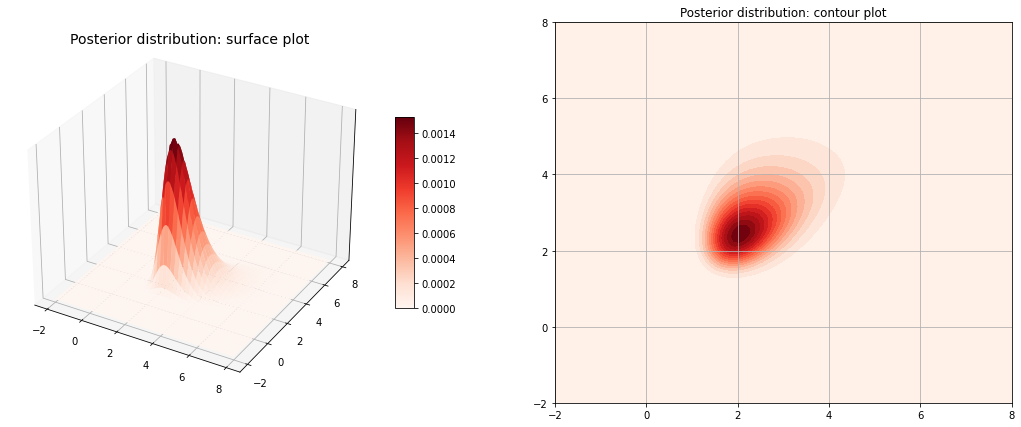

In [8]:
xs = np.linspace(-2, 8, 100)
ys = np.linspace(-2, 8, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
ZZ = np.array([np.exp(log_post_laplace(beta=[xss,yss], X=X, y=y)) for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = ZZ.reshape(xx.shape)

fig = plt.figure(figsize=(9*2, 7))

# surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx, yy, ZZ, cmap='Reds')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.axes.zaxis.set_ticks([])
ax.set_title("Posterior distribution: surface plot", y=1.03, fontsize=14)

# contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contourf(xs, ys, ZZ, 18, cmap='Reds',
            vmin=ZZ.min(), vmax=ZZ.max())
ax.grid()
ax.set_title("Posterior distribution: contour plot")
                     
plt.show()

Puis, affichons les échantillons dans $\mathbb{R}^2$, leur **histogramme 2D**, les **auto-correlation** plots et les **trace** plots.

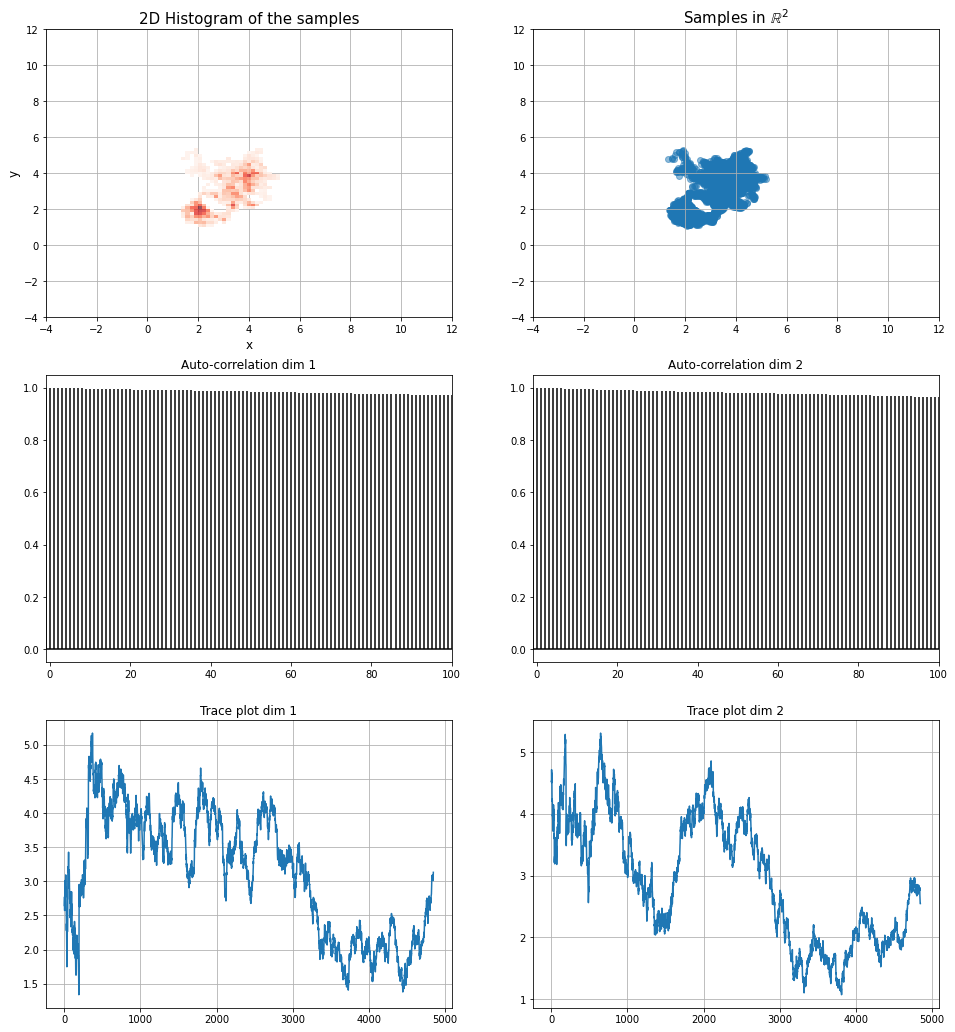

In [9]:
# get the samples
burn_in = int(num_epoch*num_samples/batch_size)
samples = betas[burn_in:]
xlim, ylim = (-4, 12), (-4, 12)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, 0], samples[:, 1], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,0], samples[:,1], alpha=.5)
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,0], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,1], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,0])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,1])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()

On observe donc que l'échantillonnage est à peu près **correct** car on reconstruit (plus ou moins) bien les contour de la posterior avec l'histogramme 2D des échantillons. On observe toutefois que l'échantillonnage n'est **pas uniforme**, avec des **"trous" dans l'histogramme** 2D. De plus, l'échantillonnage n'est pas extrêmement efficace: les échantillons sont **très corrélés** et les **trace-plots** montrent une certaine **tendance globale**. 

Ceci était prévisible comme à mesure que l'on échantillonne, les **step-sizes diminuent** et donc les **échantillons** sont naturellement **plus corrélés** car le taux de mélange de la chaîne de Markov induite par les échantillons diminue. On voit donc la **nécessité** de **pondérer** l'importance des **échantillons par les step-sizes** dans les sommes de **Monte-Carlo** lorsque l'on approxime des espérances contre la posterior.

#### 1.3.5. Distribution prédictive et prédictions

On peut alors calculer la predictive distribution et vérifier que l'on a bien une **incertitude maximale** lorsque l'on est **proche de la decision boundary** ou **loin du training set**. Notons que pour calculer la predictive distribution, qui est l'éspérance de la likelihood contre la posterior, on utilise la méthode proposée par l'artcile en **pondérant** l'importance de **chaque échantillon** dans la somme de Monte Carlo avec la **step-size** correspondante.

Afin d'obtenir des prédictions à partir de la predictive distribution, on prédit pour tout nouveau point $y^*$: $\mathrm{label}(y^*) = 2\cdot\mathbb{1}_{p(y^*|X, y, x^*) \geq p_0} - 1$ où $p_0 = 0.5$. La **decision boundary** est donc la **courbe de niveau 0.5** de la **predictive distribution**.

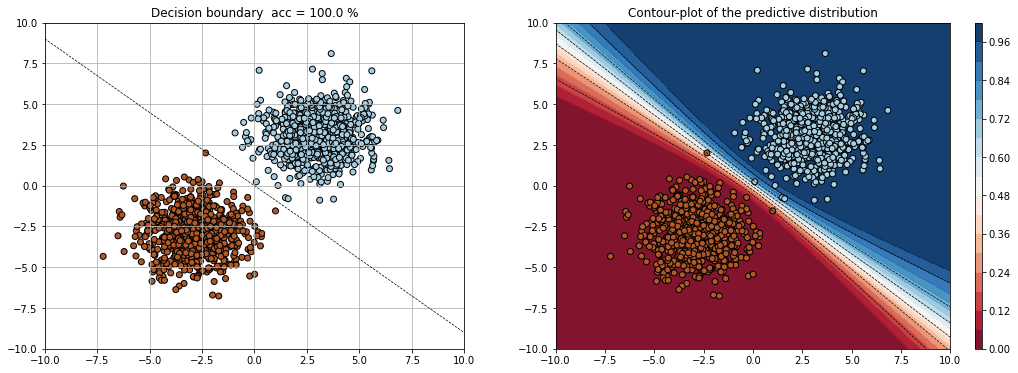

In [10]:
# approximation of the accuracy
beta = betas[-1]
acc = 100 * (np.sign(X @ beta) == y).mean()

# limits
xlim, ylim = (-4, 12), (-4, 12)

# contour of the predictive distribution
xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = predictive_MC(X_new=zz, samples=betas, burn_in=1000, weights=trackW)
ZZ = ZZ.reshape(xx.shape)

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[.5])
ax[0].set_ylim(-10, 10)
ax[0].set_xlim(-10, 10)
ax[0].set_title("Decision boundary "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

Tout d'abord, on observe sur la figure de gauche que l'on on **sépare bien les deux classes**.  

Puis, sur la figure de droite, on observe exactement le comportement espéré: on a une incertitude maximale proche de la decision boundary et loin des données d'entrainement. Ceci est utile pour **lutter contre l'overfitting**: loin des données d'entrainement, il y a apriori peu de chance pour que le modèle classifie correctement les points.

### 1.4. Application sur des données synthétiques (non-linearly spearable) 

Dans cette section, on teste notre implémentation de la SGLD sur un dataset **non-linéairement séparable** dans $\mathbb{R}^2$.  
Notre but est d'utiliser un feature mapping adéquat afin de bien séparer les données et de montrer l'efficacité des méthodes bayésiennes pour la **gestion de l'overfitting** dans ce genre de cas.  
De plus, c'est l'occasion d'utiliser la SGLD dans un espace de dimension supérieur à 2, puisque qu'on va se placer dans un espace de dimension supérieur à celui contenant les points.

#### 1.4.1. Visualisation des données

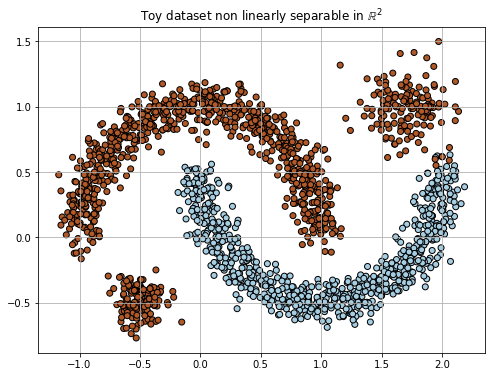

In [11]:
# load non linearly separable dataset
X, y = make_moons(n_samples=1500, noise=.09)
x1, y1 = multivariate_normal.rvs(mean=[1.7,1], cov=.03*np.eye(2), size=150), np.zeros(150)
x2, y2 = multivariate_normal.rvs(mean=[-.5,-.5], cov=.01*np.eye(2), size=150), np.zeros(150)
X = np.concatenate((X, x1, x2), axis=0)
y = np.concatenate((y, y1, y2), axis=0)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset non linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

#### 1.4.2. Application

Afin de rendre les données linéairement séparables, on **envoie les features** dans un espace de **dimension supérieure**. On considère la transformation $\phi : (x_1, x_2) \in \mathbb{R}^2 \mapsto (1, x_1, x_2, x_1x_2, x_1x_2^2, x_1^2x_2, x_1^2, x_2^2, x_1^3, x_2^3) \in \mathbb{R}^{10}$, puis on map chacun des points du training set de $\mathbb{R}^2$ dans $\mathbb{R}^{10}$.  
On effectue ensuite la classification dans $\mathbb{R}^{10}$ avec cette nouvelle représentation des points (ce qui revient à utiliser un noyau polynomial de degré 3)

In [12]:
# polynomial transformation of the features
poly = PolynomialFeatures(3, include_bias=True)
phi_X = poly.fit_transform(X)

print(f"Number of dimension of the new covariates: {phi_X.shape[1]}.")

Number of dimension of the new covariates: 10.


In [13]:
a = .6
b = 50
gamma = .7
batch_size = 10
n_iter = 5000
beta_0 = np.ones(phi_X.shape[1])

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_logreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 5441.92it/s]


Done in 0.92 s.
Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:01<00:00, 2636.54it/s]


Done in 1.9 s.


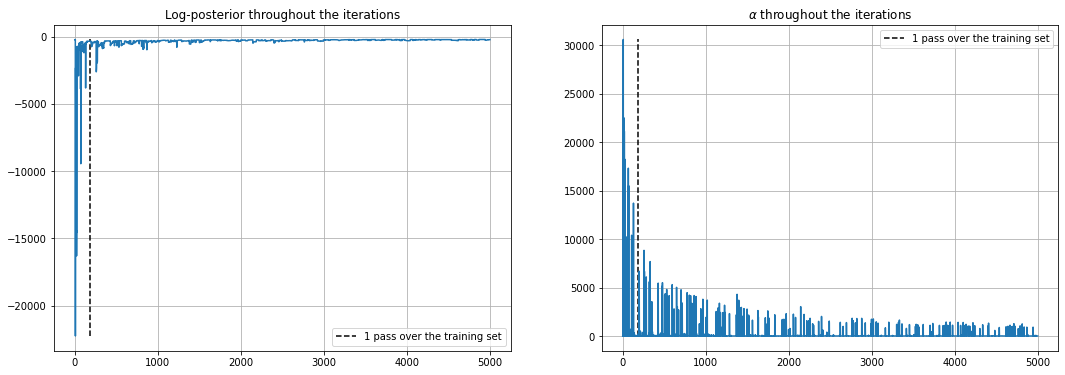

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]
burn_in = int(num_epoch*num_samples/batch_size)

# plot log-posterior 
ax[0].vlines(burn_in, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(burn_in, ymin=trackA.min(), ymax=trackA.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

#### 1.4.3. Distribution prédictive et prédictions

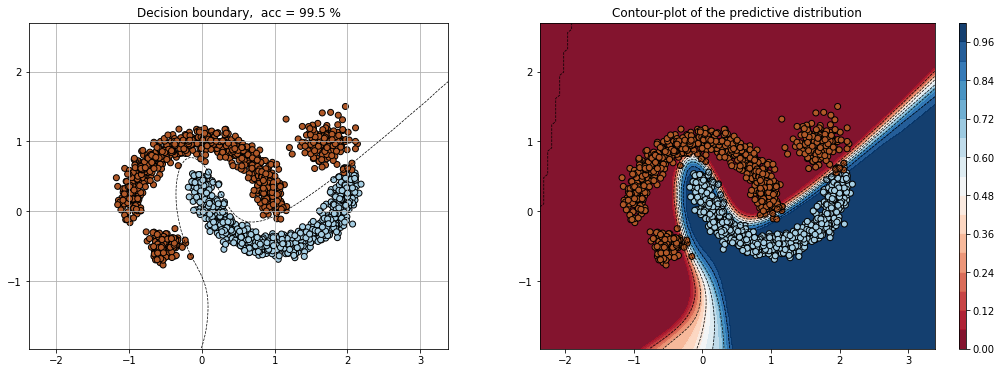

In [15]:
# approximation of the accuracy
beta = betas[-1000:].mean(0)
acc = 100 * (np.sign(phi_X @ beta) == y).mean()

xlim, ylim = (X[:,0].min()-1.2, X[:,0].max()+1.2), (X[:,1].min()-1.2, X[:,1].max()+1.2)

# contour of the predictive distribution
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
phi_zz = poly.transform(zz)
ZZ = predictive_MC(X_new=phi_zz, samples=betas, burn_in=burn_in, weights=trackW)
ZZ = ZZ.reshape(xx.shape).T

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
#x = np.linspace(-10, 10, 10)
#ax[0].plot(x, f(x), linestyle='--', color='k')
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[0.5])
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

Tout d'abord, on observe que le données sont bien séparées à l'aide du feature mapping de $\mathbb{R}^3$ dans $\mathbb{R}^{10}$. De plus, on observe également le bénéfice des méthodes bayésiennes: la predictive distribution montre des zones de grande incertitude, i.e $p(y^*|x^*, X, y) \approx 0.5$.  
Ceci montre bien en quoi utiliser la SGLD (pour échantillonner selon la posterior) peut nous aider à **lutter** contre **l'overfitting**.

### 1.5. Application sur des données réelles

#### 1.5.1. Import des données

Pour tester notre modèle sur des **données plus complexes**, on utilise le dataset [HTRU](https://archive.ics.uci.edu/ml/datasets/HTRU2#). 
C'est un dataset contetant **17,898 échantillons**, chacun ayant **8 attributs** (features) et une **classe binaire** (stable, unstable). Il ne contient pas de valeurs manquantes.

In [16]:
# load the dataset
data = pd.read_csv("HTRU_2.csv", header=None)
print(f"Number of instances: {data.shape[0]}")
print(f"Number of attributes: {data.shape[1]-1}")
print(f"Number of classes: {len(np.unique(data[data.columns[-1]].values))}\n")
data.head()

Number of instances: 17898
Number of attributes: 8
Number of classes: 2



,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


#### 1.5.2. Prétraitement

Après quelques tests, nous avons réalisé qu'il était nécessaire de **centrer et normaliser les données**. En effet, si cette étape n'est pas réalisée, la phase d'optimisation est extrêmement chaotique et entraîne de l'overflow dans les calculs. On prétraite donc les données afin que chaque **feature** ait une **moyenne nulle** et un **écart type unitaire**.

Nous pouvons intepréter cette étape comme l'étape de **conditionnement** décrite dans l'article, où l'on multiplie les gradients par une matrice $M$, ce qui revient à multiplier la matrice des données par cette matrice par formule de la chaîne.

In [17]:
# pre-process data
X_ = data[data.columns[:-1]].values

# pre-process labels
y_ = 2 * (data[data.columns[-1]]==0).values - 1

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=.25, random_state=42)

print(f"Number of training examples: {len(X_train)}.")
print(f"Number of testing examples: {len(X_test)}.")

Number of training examples: 13423.
Number of testing examples: 4475.


In [18]:
# fit scaler on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# scale test data
X_test = scaler.transform(X_test)

#### 1.5.3. Application

In [19]:
a = .1
b = 75
gamma = .8
batch_size = 10
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxiliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]

# computing both alphas and log-posterior at each step  
print(f"Computing both the log-posterior, the alphas and storing the weights at each step:")
time.sleep(1)
betas, trackA, trackW, trackL = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size, bool_trackL=True, bool_trackA=True, bool_trackW=True)

Without computing any auxiliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 5483.92it/s]


Done in 0.91 s.
Computing both the log-posterior, the alphas and storing the weights at each step:


100%|██████████| 5000/5000 [00:02<00:00, 1729.78it/s]


Done in 2.89 s.


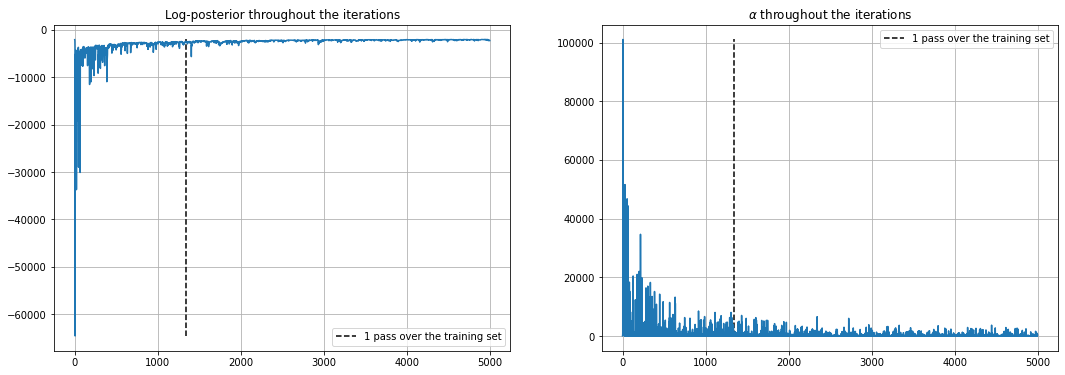

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X_train.shape[0]

# plot log-posterior 
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=trackL.min(), ymax=trackL.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(trackL)
ax[0].set_title("Log-posterior throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot alphas
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=trackA.min(), ymax=trackA.max()+.5, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(trackA)
ax[1].set_title("$\\alpha$ throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

#### 1.5.4. Predictions et courbes de score de classififcation

On étudie ici l'évolution de l'**accuracy à chaque itération** $t$ lorsque l'on prend comme point estimate $\hat{\beta} = \beta_t$. On calule donc à chaque itération l'erreur de classification $\mathrm{acc} = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{\mathrm{sign}(\beta_t^{\top}x_i = y_i\}}$.

On espère alors que l'accuracy sur le training set et le testing se **stablise assez rapidement** (phase d'optimisation) avant d'entrer dans une longue phase où elle est assez haute et **n'évolue plus** (phase d'échantillonnage).

In [21]:
# get a point estimates of the parameter (naive strategy : mean of the last 1000 samples)
beta = betas[-1000:].mean(0) 

# get the accuracy on the training set
acc_train = 100 * (np.sign(X_train @ beta) == y_train).mean()
print(f"Accuracy on the training set: {round(acc_train, 2)}%")

# get the accuracy on the testing set
acc_test = 100 * (np.sign(X_test @ beta) == y_test).mean()
print(f"Accuracy on the testing set: {round(acc_test, 2)}%")

Accuracy on the training set: 96.79%
Accuracy on the testing set: 96.69%


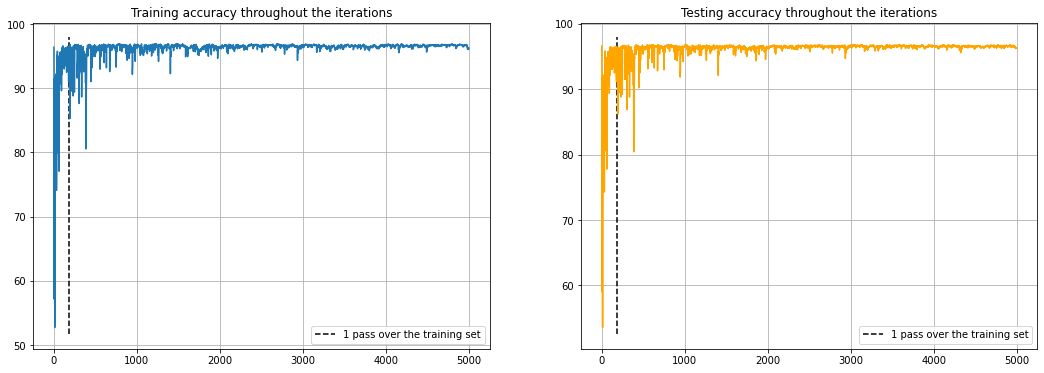

In [22]:
# get the training accuracy at each iteration 
accs_train = get_acc_iter(X_train, y_train, samples=betas)

# get the testing accuracy at each iteration 
accs_test = get_acc_iter(X_test, y_test, samples=betas)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=accs_train.min()-1, ymax=accs_train.max()+1, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(accs_train)
ax[0].set_title("Training accuracy throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=accs_test.min()-1, ymax=accs_train.max()+1, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(accs_test, c='orange')
ax[1].set_title("Testing accuracy throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

#### 1.5.5. Moyennes et écart type des performances sur 30 exécutions de l'algorithme

Comme nous manipulons ici un dataset réel et que les résultats de l'algorithme s

In [23]:
# perfrom SGLD to get initialization quantities
a = .01
b = 30
gamma = .7
batch_size = 10
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000
dim = X_train.shape[1]
print(f"SGLD (initialization):")
time.sleep(1) # avoid some printing issue
betas = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)

# re-inject last sample in the next run
beta_0 = betas[-1]
    
# multiple runs 
n_avg = 30
mult_samples = np.zeros((n_avg, n_iter+1, dim))
seedValues = np.random.randint(1000000, size=n_avg)
for ii in range(n_avg):
    np.random.seed(seedValues[ii]) 
    print(f"\nStep {ii+1}: in progress...")
    time.sleep(.5) # avoid some printing issue
    betas = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)
    mult_samples[ii] = betas
    time.sleep(.5) # avoid some printing issue

SGLD (initialization):


100%|██████████| 5000/5000 [00:00<00:00, 5347.74it/s]


Done in 0.94 s.

Step 1: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5292.84it/s]


Done in 0.95 s.

Step 2: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5550.36it/s]


Done in 0.9 s.

Step 3: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5061.64it/s]


Done in 0.99 s.

Step 4: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5131.76it/s]


Done in 0.98 s.

Step 5: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5055.43it/s]


Done in 0.99 s.

Step 6: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5156.52it/s]


Done in 0.97 s.

Step 7: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5024.90it/s]


Done in 1.0 s.

Step 8: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5287.81it/s]


Done in 0.95 s.

Step 9: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5493.21it/s]


Done in 0.91 s.

Step 10: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5477.89it/s]


Done in 0.92 s.

Step 11: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5279.65it/s]


Done in 0.95 s.

Step 12: in progress...


100%|██████████| 5000/5000 [00:01<00:00, 4994.44it/s]


Done in 1.0 s.

Step 13: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5080.05it/s]


Done in 0.99 s.

Step 14: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5130.78it/s]


Done in 0.98 s.

Step 15: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5064.89it/s]


Done in 0.99 s.

Step 16: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5058.02it/s]


Done in 0.99 s.

Step 17: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5169.52it/s]


Done in 0.97 s.

Step 18: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5158.26it/s]


Done in 0.97 s.

Step 19: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5147.62it/s]


Done in 0.97 s.

Step 20: in progress...


100%|██████████| 5000/5000 [00:01<00:00, 4965.94it/s]


Done in 1.01 s.

Step 21: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5476.45it/s]


Done in 0.91 s.

Step 22: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5309.73it/s]


Done in 0.94 s.

Step 23: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5733.89it/s]


Done in 0.87 s.

Step 24: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5102.45it/s]


Done in 0.98 s.

Step 25: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5191.82it/s]


Done in 0.96 s.

Step 26: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5111.09it/s]


Done in 0.98 s.

Step 27: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5195.79it/s]


Done in 0.96 s.

Step 28: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5132.91it/s]


Done in 0.98 s.

Step 29: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5080.88it/s]


Done in 0.99 s.

Step 30: in progress...


100%|██████████| 5000/5000 [00:00<00:00, 5617.91it/s]


Done in 0.89 s.


In [24]:
# get a point estimates of the parameter (naive strategy : mean of the last 1000 samples)
accs_train = np.asarray([100 * (np.sign(X_train @ mult_samples[ii, -1000:, :].mean(0)) == y_train).mean() for ii in range(n_avg)])

# get the accuracy on the training set
print(f"Mean accuracy on the training set over the 30 runs: {round(accs_train.mean(), 2)}%.")
print(f"Std accuracy on the training set over the 30 runs: {round(accs_train.std(), 2)}.")

# get the accuracy on the testing set
accs_test = np.asarray([100 * (np.sign(X_test @ mult_samples[ii, -1000:, :].mean(0)) == y_test).mean() for ii in range(n_avg)])
print(f"\nMean accuracy on the testing set over the 30 runs: {round(accs_test.mean(), 2)}%.")
print(f"Std accuracy on the testing set over the 30 runs: {round(accs_test.std(), 2)}%.")

Mean accuracy on the training set over the 30 runs: 96.71%.
Std accuracy on the training set over the 30 runs: 0.05.

Mean accuracy on the testing set over the 30 runs: 96.73%.
Std accuracy on the testing set over the 30 runs: 0.05%.


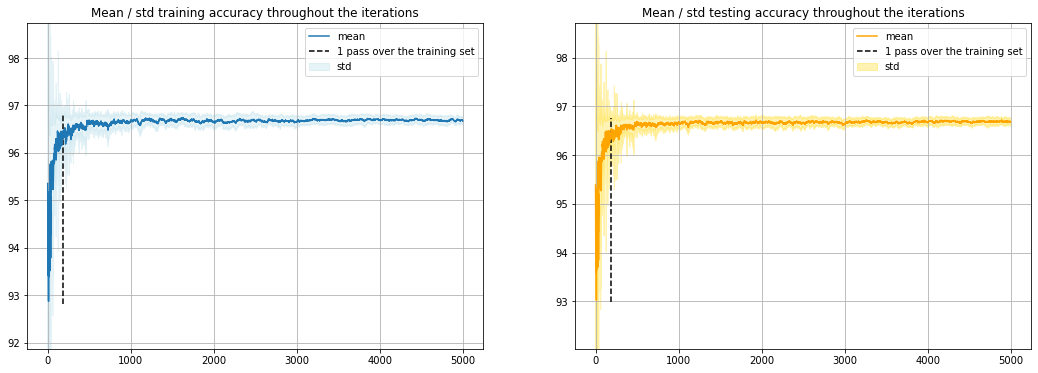

In [25]:
# get the training accuracy at each iteration for each execution of the algorithm
mult_accs_train = np.zeros((n_avg, n_iter))
for ii in range(n_avg):
    mult_accs_train[ii] = get_acc_iter(X_train, y_train, samples=mult_samples[ii])

# get the training accuracy at each iteration for each execution of the algorithm
mult_accs_test = np.zeros((n_avg, n_iter))
for ii in range(n_avg):
    mult_accs_test[ii] = get_acc_iter(X_test, y_test, samples=mult_samples[ii])

# get the training accuracy at each iteration 
mean_train = mult_accs_train.mean(0)
upper_train = mean_train + mult_accs_train.std(0)
lower_train = mean_train - mult_accs_train.std(0)

# get the training accuracy at each iteration 
mean_test = mult_accs_test.mean(0)
upper_test = mean_test + mult_accs_test.std(0)
lower_test = mean_test - mult_accs_test.std(0)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=mean_train.min()-.05, ymax=mean_train.max()+.05, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(mean_train, label='mean')
ax[0].set_ylim(mean_train.min()-1, mean_train.max()+2)
ax[0].fill_between(np.arange(len(lower_train)), lower_train, upper_train,
                   color='lightblue', alpha=.3, label='std')
ax[0].set_title("Mean / std training accuracy throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=mean_test.min()-.03, ymax=mean_test.max()+.05, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(mean_test, color='orange', label='mean')
ax[1].set_ylim(mean_test.min()-1, mean_test.max()+2)
ax[1].fill_between(np.arange(len(lower_test)), lower_test, upper_test,
                   color='gold', alpha=.3, label='std')
ax[1].set_title("Mean / std testing accuracy throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

Les **résultats** sont donc **très stables** dans la **phase d'échantillonnage**, mais **beaucoup moins** dans la **phase d'optimisation**. 

L'**instabilité** dans la **phase d'optimisation** est due au fait que l'on accepte toutes les mises à jours malgré la **variabilité des gradients stochastiques** et les **step-sizes plus élevées**. Toutefois, cette variabilité permet d'accéder très rapidement au zone de forte probabilité, sans avoir à calculer des gradients induisant la manipulation du dataset entier. Les **faiblesses** de la **SGLD font ses forces** et vice-versa.

#### 1.5.6. Distribution prédictive et bénéfices des méthodes bayésiennes 

Il est à présent intéressant de **tirer profit** des **méthodes Bayesiennes**.  

En effet, calculons la distribution prédictive de chacun des testing examples afin d'analyser la robustesse de notre prédiction. Logiquement, pour un point donné on devrait observer:

- une probabilité **proche de 1** lorsque le **label** prédit est **1** et qu'il est **bien classifié**, 

- une probabilité **proche de 0** lorsque le **label** prédit est **-1** et qu'il est **bien classifié**,

- une probabilité **proche de 0.5** lorsque le **label** est **mal-classifié**.

Afin d'obtenir des prédictions à partir de la distribution prédictive, on prédit pour tout nouveau point $y^*$: $\mathrm{label}(y^*) = 2\cdot\mathbb{1}_{p(y^*|X, y, x^*) \geq p_0} - 1$ où $p_0 = 0.5$.

In [26]:
# get predictive distribution for each testing examples
pred_test = predictive_MC(X_new=X_test, samples=betas, burn_in=burn_in, weights=trackW)

# get a hard prediction
y_pred = 2 * (pred_test >= .5) -1

# get misclassified examples
idxs_misclass = np.where(y_pred != y_test)[0]

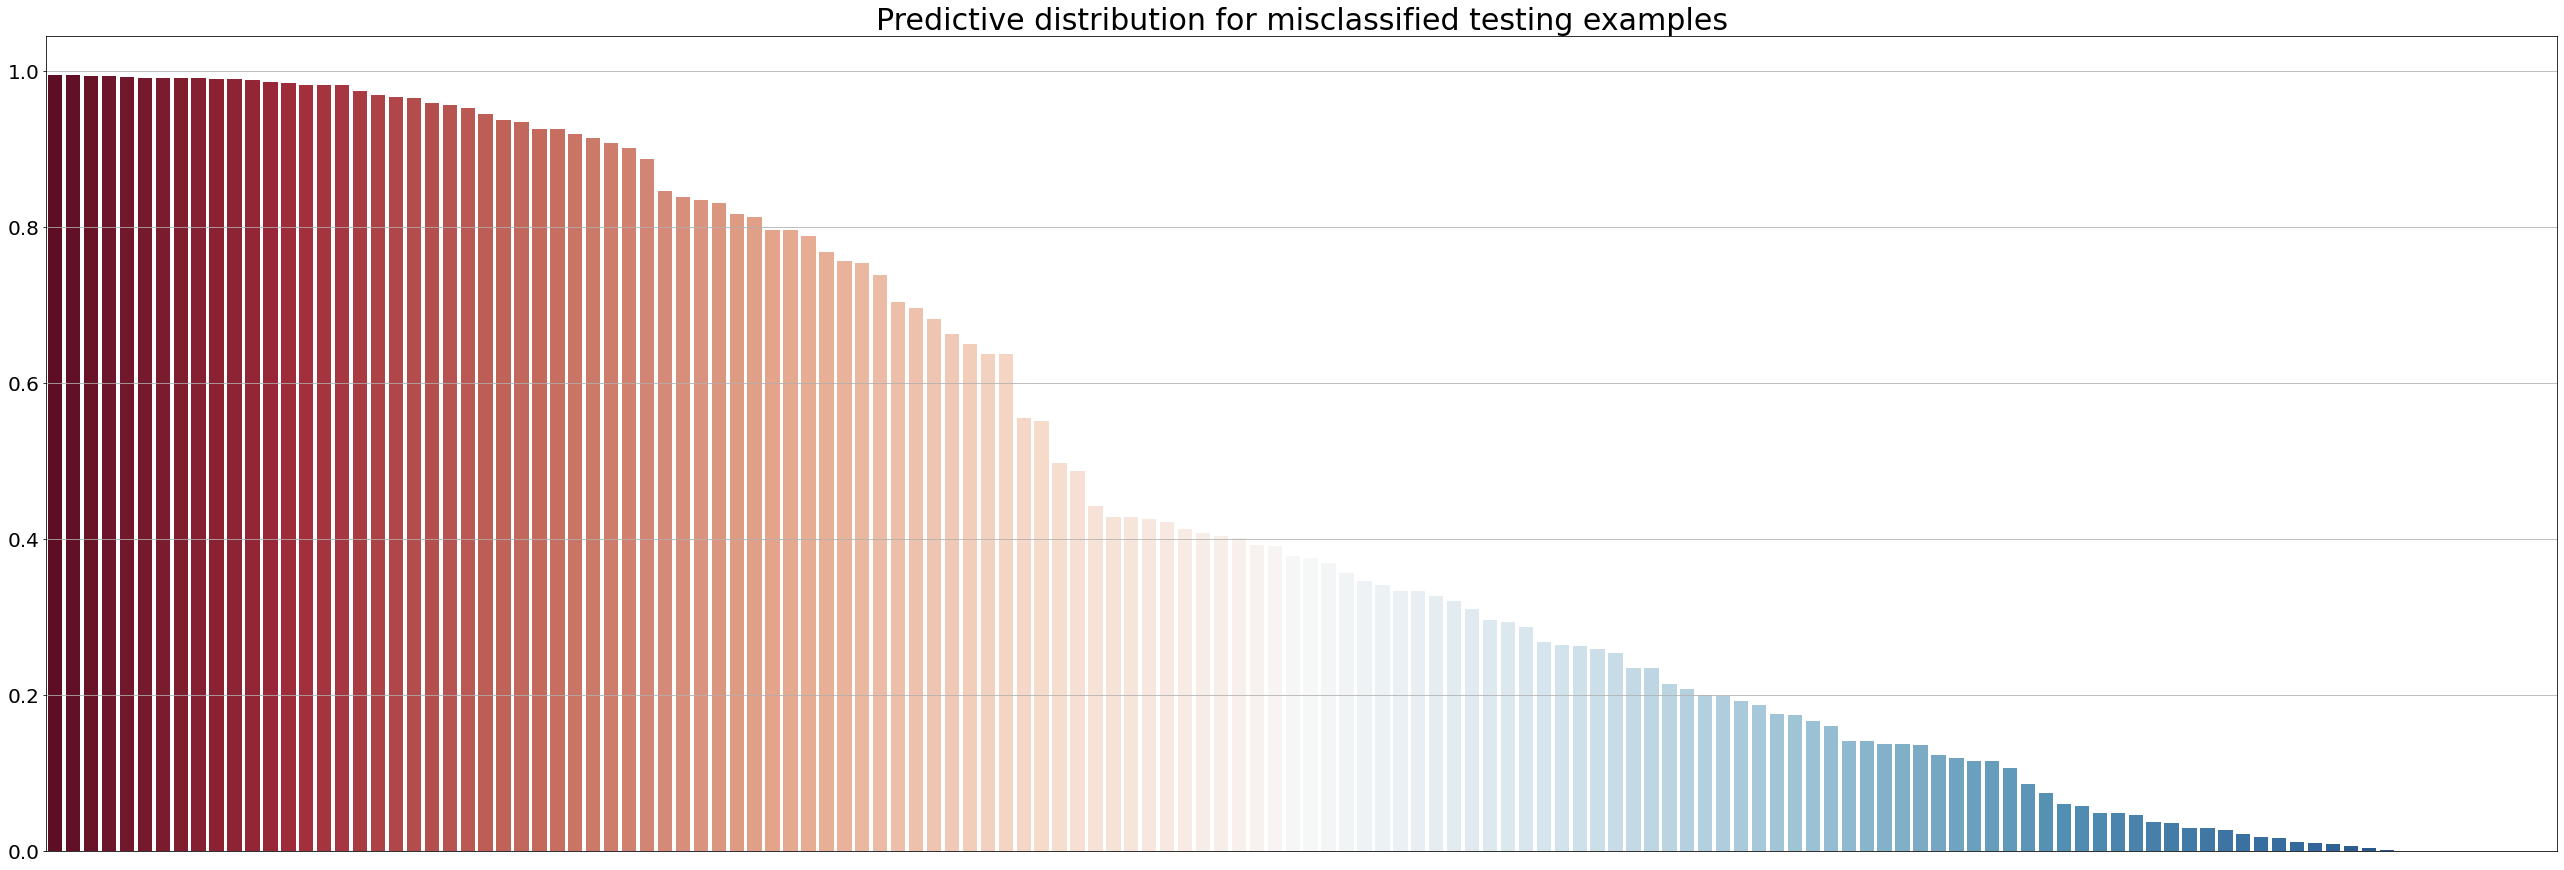

In [27]:
fig, ax = plt.subplots(figsize=(45,15))
bar = sns.barplot(y=np.flip(np.sort(pred_test[idxs_misclass])), 
            x=[str(x) for x in idxs_misclass[np.flip(np.argsort(pred_test[idxs_misclass]))]], 
            palette='RdBu', orient='v', ax=ax);
ax.axes.xaxis.set_ticks([])
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_title("Predictive distribution for misclassified testing examples", fontsize=30)
ax.grid();

Le graphe ci dessus montre, par ordre de **prédictive distribution** décroissante, la predictive distribution pour chacun des testing examples mal-classifié. 
On espererait **idéalement** que ces dernières soient aux alentours de **0.4 ~ 0.6**, mais ce n'est pas le cas. 

On observe notamment des probabilités **très proches de 1** (forte confiance en une prédiction d'un label par 1) et des probabilités **très proches de 0** (forte confiance en une prédiction d'un label par 1).

Comme selon certaines exécutions de l'algorithme, des testing examples puevent être bien classifiées certaines fois et d'autres non, nous avons affiché **ce graphe** pour **une éxécution donnée de l'algorithme**, sans moyenner les résultats. Outre une étude précise de la robustesse de l'algorithme (faite ci-dessous), ce graphe permet, d'un coup d'oeil, de visualiser quelle est la distribution des distributions predictives sur les testing examples mal classifiés, pour une exécution de l'algorithme.

#### 1.5.7. Un critère de robustesse 

Afin d'avoir un **critère de robustesse** quant à la gestion de l'incertitude pour les mauvaises prédictions, on peut calculer un critère défini à partir l'**entropie binaire** de la **predictive distribution** sur les **testing examples mal-classifiés**.  

En effet, notons $\mathcal{X}^* = \{x^*_{1}, ..., x^*_{p} \}$ les testing examples mal classifiés, i.e les testing examples tels que $2\cdot\mathbb{1}_{p(y^*|X, y, x^*) \geq 0.5} - 1 \neq y^*$.  

Comme on l'a précisé, on voudrait idéalement que ces points aient des distributions prédictive d'incertitude maximale, i.e de variance maximale, soit que $\forall i \in \{1,...,p\}, \, p(y_i^*=1|X, y, x_i^*) \approx p(y_i^*=0|X, y, x_i^*) \approx 0.5$ comme on manipule des variables aléatoires binaires à valeur dans $\{-1, 1\}$.  

Or l'entropie d'une variable aléatoire $X$ à valeur dans $\{-1, 1\}$ est maximale lorsque $\mathbb{P}(X=1) = \mathbb{P}(X=-1) = 0.5$. Ainsi, en utilisant la moyenne de l'entropie binaire pour chacun des testing examples mal classifiés: $H(\mathcal{X}^*) = \frac{1}{p} \sum_{i=1}^p - p(y_i^*=1|X, y, x_i^*) \, \log_2\left[p(y_i^*=1|X, y, x_i^*))\right] - \left[1-p(y_i^*=1|X, y, x_i^*)\right] \, \log_2\left[1 - p(y_i^*=1|X, y, x_i^*)\right]$, ce critère permet de mesurer la gestion de l'incertitude pour les mauvaises prédictions.  

Plus ce **critère** est **grand**, plus le modèle est **indécis** lorsqu'il effectue des **mauvaises prédictions** et donc plus le modèle est **robuste** et on tend vers le comportement souhaité. Inversément, plus ce **critère** est **faible**, plus le **modèle** est **confiant** lorsqu'il effectue des **mauvaises prédictions** et donc le modèle n'est **pas robuste**.

Nous calulons alors ce critère en le moyennat sur les 30 éxécutions de l'algorithme effectuées précedemment.

In [28]:
# get predictive distribution for each testing examples
preds_test = np.asarray([predictive_MC(X_new=X_test, samples=mult_samples[ii, :, :], burn_in=burn_in, weights=trackW) for ii in range(n_avg)])

# get a hard prediction
y_preds = 2 * (preds_test >= .5) - 1

# get misclassified examples
idxs_misclass = np.asarray([np.where(y_preds[ii] != y_test)[0] for ii in range(n_avg)])

# get robustness criterions 
crits = np.asarray([get_criterion_ent(pred_distrib=preds_test[ii], idxs_misclass=idxs_misclass[ii]) for ii in range(n_avg)])
print(f"Mean robustness criterion: {round(crits.mean(), 5)}.")
print(f"Std robustness criterion: {round(crits.std(), 5)}.")

Mean robustness criterion: 0.53174.
Std robustness criterion: 0.00988.


/Users/louisbouvier/Documents/MVA-MPRO/MVA/S2/Learning/Bayesian Machine Learning/BML_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Il sera alors interessant de **comparer ce résultat** avec **d'autres méthodes** d'échantillonnage.

## 2. Adaptative Symmetric Random Walk

Dans cette section, on va utiliser une **autre méthode** d'échantillonnage selon la posterior et comparer les résultats à ceux obtenus précedemment avec la SGLD. Nous allons utiliser une méthode d'**échantillonage pur**, où nous n'avons pas de phase d'optimisation de la log-posterior: un **adaptive symmetric random walk** avec une **proposal distribution gaussienne**. La différence avec un symmetric random walk simple est que l'on **apprend la covariance de la proposal distribution** au cours des itérations **à partir des échantillons générés**.

### 2.1. Un bref récapitulatif de la méthode

#### 2.1.1. Rappel sur le symmetric random walk

On rappelle le principe du symmetric random walk classique où l'on échantillonne selon une **loi cible** $\pi$ avec une proposal distribution gaussienne $q_{\Gamma}(\cdot, x) \sim \mathcal{N}(x, \Gamma)$, à **chaque itération** $t$:

- on génère un candidat $\hat{\theta}_t \sim q_{\Gamma}(\cdot,\theta_{t-1})$,

- on calcule la probabilité d'acceptation du candidat $\alpha(\hat{\theta}_t, \theta_{t-1}) = \mathrm{min}(1, \pi(\hat{\theta}_t) \, / \, \pi(\theta_{t-1})$,

- on génère $u \sim U([0, 1])$ et $\theta_t \leftarrow \hat{\theta}_t$ si $\alpha \geq u$ sinon $\theta_t \leftarrow \theta_{t-1}$.

#### 2.1.2. Avec covariance adptative

On note $(\mu_t, \Gamma_t)_{t\geq0}$ les paramètres à l'itération $t$. Pour $(\Delta_t)_{t\geq0}$ une suite de gain décroissante vers 0 mais telle que $\sum_t \Delta_t = + \infty$ (pour la convergence de l**'approximation stochastique**, comme avec $(\epsilon_t)_{t\geq 0}$ pour la SGLD), à chaque itération $t$:

- on génère $X_t$ selon une étape de symetric random walk classique de proposal $q_{\Gamma}(\cdot,\Gamma)$ (comme décrit ci-dessus),

- on met à jour $\mu$ : $\mu_{t+1} = \mu_t + \Delta_{t+1} \, (\theta_{t+1} - \mu_t)$,

- on met à jour $\Gamma$ : $\Gamma_{t+1} = \Gamma_t + \Delta_{t+1} \, \left((\theta_{t+1} - \mu_t) \, (\theta_{t+1} - \mu_t)^{\top} - \Gamma_{t}\right)$.

On utilisera par la suite $(\Delta_t)_{t\geq0} = (\frac{1}{t^\gamma})_{t\geq0}$ où $\gamma \in (0.5,1]$ sera choisit empiriquement comme pour la SGLD.

De plus, notons que pour des raisons de **stabilité numérique**:

- on ajoute à chaque étape un terme de régularisation afin d'éviter que la covaraince devienne singulière, pour $\mathrm{reg}>0$ un paramètre de régularisation fixé empiriquement, la mise à jour devient alors $\Gamma$ : $\Gamma_{t+1} = \Gamma_t + \Delta_{t+1} \, \left((\theta_{t+1} - \mu_t) \, (\theta_{t+1} - \mu_t)^{\top} - \Gamma_{t}\right) + \mathrm{reg} \cdot I_d$,

- on calcule à chaque étape $\log(\alpha) = \mathrm{min}(0, \log \pi(\tilde{\theta_t}) - \log \pi(\theta_t))$ pour pouvoir gérer des valeurs de densité cible très faibles.

#### 2.1.3. Pourquoi n'utilisons pas un symmetric random walk classique ?

Un symmetric random walk classique est très efficace lorsque la distribution est **sensiblement gaussienne**, i.e lorsque les **sublevel sets** de la **densité cible** sont **ellipsoïdaux**.  

Ici, les plots précédents montrent que les **sub-level sets** de la posterior distribution $p(\beta|X,y)$ sont assez **anisotropes** et étirés selon une certaine direction: la prior de laplace entaîne une queue lourde pour la posterior.  

Pour pouvoir échantillonner efficacement dans **la queue de la distribution**, on devrait utiliser une **proposal** distribution de **grande variance**, ce qui entraînerait **beaucoup de rejet** et donc un algorithme **plus long** pour obtenir assez d'échantillons pour approximer des predictive distributions.

L'**adaptative** symmetric random walk est alors utilisé pour **pouvoir échantillonner** dans la **queue de la distribution** tout en **évitant d'avoir un taux d'acceptation trop faible**  car la covariance de la proposal distribution est apprise au cours des itérations afin de s'adapter aux différentes zones dans lesquelles on échantillonne. 

#### 2.1.4. Que devrait-on éspérer par rapport à la SGLD ?

Comme on utilise ici une méthode MCMC classique, chaque itération nécessite de manipuler tout le training set: on doit calculer la probabilité d'acceptation  des candidats à chacune des itérations, qui est un rapport de posterior distribution donc qui nécessite tous les training examples (pas de calculs par batch). On devrait donc avoir un **échantillonnage plus lent**, surtout lorsque le dataset est grand. Il sera donc intéressant de comparer les running times, surtout sur de grand datasets.

De plus, comme on utilise ici une méthode purement axé échantillonage (et pas optimisation), on devrait avoir un **échantillonnage de meilleur qualité** (échantillons moins corrélés, trace-plots plus uniformes). 

#### 2.1.5. Une précision sur l'évalution des exécutions de l'algorithme

Enfin, précisons que pour toute la suite, afin de pouvoir effectuer des comparaisons pertinentes, **nous exécuterons toujours** la **SGLD une première fois fois** et nous réinjecterons le **dernier échantillon** en **échantillon initial** de l'éxécution de l'**adaptive symmetric random walk**. Nous utilisons cette méthode afin d'**éviter* d'**initialiser** les chaînes de Markov dans des **zones  de probabilité quasi-nulles**. En effet, si une méthode de type symmetric random walk est initialisé dans une zone de probabilité nulle numériquement, tous les échantillons seront acceptés sans discernement car la probabilité d'acceptation des candidiats à chaque itération est définie par $\alpha(\hat{\theta}_t, \theta_{t-1}) = \mathrm{min}(1, \pi(\hat{\theta}_t) \, / \, \pi(\theta_{t-1}))$ si $\pi(\theta_{t-1}) > 0$ et $1$ sinon. En revanche, la phase initiale d'optimisation de la SGLD permet de s'échapper de ce type de zones de probabilité quasi-nulles. On **combine** donc les **deux méthodes**.

### 2.2 Implementation

Une implémentation du symetric random walk classique est également fournie. 

In [29]:
def srwMH(n_samples, cov, init_sample, log_target, dim=2):
    '''
    Symetric Random Walk Hasting Metropolis algorithm.
    Parameters:
      n_samples: int, number of samples to generate
      cov: np.array, covariance of the proposal distribution
      init_sample: np.array, initial sample
      target: callable, target distrbution
    Returns:
      samples: np.array, generated samples
      accept_ratio: float, acceptance ratio (#{accepted_candidates} / #{number_iterations})
      alphas: np.array, acceptance probability at each step
    '''
    start = time.time()
    samples = np.vstack((init_sample, np.zeros((n_samples, dim))))
    alphas = np.zeros(n_samples)
    accept_bools = np.zeros(n_samples)
    
    for ii in tqdm(range(n_samples)):
        
        # draw a candidate
        current = samples[ii]
        proposal = multivariate_normal(mean=current, cov=cov)
        cand = proposal.rvs(size=1)
        
        # compute acceptance ratio
        log_alpha = min(0, log_target(cand)) - log_target(current) 
        alpha = np.exp(log_alpha)
        alphas[ii] = alpha
        
        # accept with proba alpha
        u = np.random.rand()
        accept_bool = (alpha > u)
        accept_bools[ii] = accept_bool
        if accept_bool:
            samples[ii+1] = cand     # accept candidate
        else:
            samples[ii+1] = current   # reject candidate
                                
    # compute acceptance ratio
    accept_ratio = np.mean(accept_bools)
    
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    return samples, accept_ratio, alphas

In [30]:
def adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, log_target, c=1, dim=2, reg=1, verbose=False):
    '''
    Adaptive symetric Random Walk Hasting Metropolis algorithm.
    Parameters:
      n_samples: int, number of samples to generate
      init_mu: np.array, initial mean of the proposal distribution
      init_cov: np.array, initial covariance of the proposal distribution
      init_sample: np.array, initial sample
      gamma: float, controls the decreasing speed of the step size
      c: float, weight to ponderate proposal covariance at each iteration (advanced setting, keep it to 1 in general)
      target: callable, target distrbution
      reg: float, used to control singular covariance matrices problem
    Returns:
      samples: np.array, generated samples
      accept_ratio: float, acceptance ratio (#{accepted_candidates} / #{number_iterations})
      alphas: np.array, acceptance probability at each step
    '''
    start = time.time()
    samples = np.vstack((init_sample, np.zeros((n_samples, dim))))
    alphas = np.zeros(n_samples)
    accept_bools = np.zeros(n_samples)
    
    # initialize parameters
    mus = np.vstack((init_mu, np.zeros((n_samples, dim))))
    covs = np.vstack((init_cov[None, :], np.zeros((n_samples, dim, dim))))
    
    for ii in tqdm(range(n_samples)):
        
        # draw a candidate
        current = samples[ii]
        proposal = multivariate_normal(mean=current, cov=c*covs[ii])
        cand = proposal.rvs(size=1)
        
        # compute acceptance ratio
        log_alpha = min(0, log_target(cand)) - log_target(current) 
        alpha = np.exp(log_alpha)
        alphas[ii] = alpha
        
        # accept with proba alpha
        u = np.random.rand()
        accept_bool = (alpha > u)
        accept_bools[ii] = accept_bool
        if accept_bool:
            samples[ii+1] = cand     # accept candidate
        else:
            samples[ii+1] = current   # reject candidate
                                
        # update parameters
        mus[ii+1] = mus[ii] + (1/((ii+1)**gamma)) * (samples[ii+1] - mus[ii])
        covs[ii+1] = covs[ii] + (1/((ii+1)**gamma)) * ((samples[ii+1] - mus[ii]) @ (samples[ii+1] - mus[ii]).T - covs[ii]) \
                                                                                  + reg * (1/((ii+1)**(gamma))) * np.eye(dim) 
        if verbose:
            print(f"alpha {ii}: {alphas[ii]}.")
            print(f"cov {ii+1}: {covs[ii+1]}.")
            
    # compute acceptance ratio
    accept_ratio = np.mean(accept_bools)
    
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    return samples, accept_ratio, alphas

### 2.3 Application sur des données synthétiques (linéairement séparables)

On conserve ici le même dataset linéairement spéarable dans $\mathbb{R}^2$ que précedemment afin de tester notre implémentation. 

#### 2.3.1. Application

On échantillonne afin d'avoir un **taux d'acceptation** autour de **30%**, afin d'explorer efficacement le support de la posterior.

In [31]:
# make sure we manipulate the good dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

In [32]:
# target distribution
log_target = lambda beta: log_post_laplace(beta, X, y)

print("SGLD (for initaialization) :")
time.sleep(.5) # avoid some printing issue
a = 1
b = 20
gamma = .6
batch_size = 5
beta_0 = np.random.rand(X.shape[1])
n_iter = 5000
betas = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size)
init_mu = betas[-100:].mean(0)
init_sample = betas[-1]

dim = X.shape[1]
n_samples = 5000
init_cov =  2 * np.eye(dim)
init_mu = np.zeros(dim)
init_sample = np.ones(dim)
gamma = .7
print("\nAdaptive symmetric random walk :")
time.sleep(.5)
samples, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, log_target=log_target)
print("Acceptance ratio: {}".format(accept_ratio))

SGLD (for initaialization) :


100%|██████████| 5000/5000 [00:01<00:00, 4751.70it/s]


Done in 1.05 s.

Adaptive symmetric random walk :


100%|██████████| 5000/5000 [00:02<00:00, 2221.57it/s]


Done in 2.25 s.
Acceptance ratio: 0.307


On observe donc un temps de calcul supérieur à celui obtenu avec SGLD. En effet, pour obtenir 5000 échantillons (sans calculer les log-posterior et les $\alpha$ à chaque itération), on avait un temps de calcul autour de 0.85 s. La **SGLD** est donc **plus de deux fois plus rapide**.

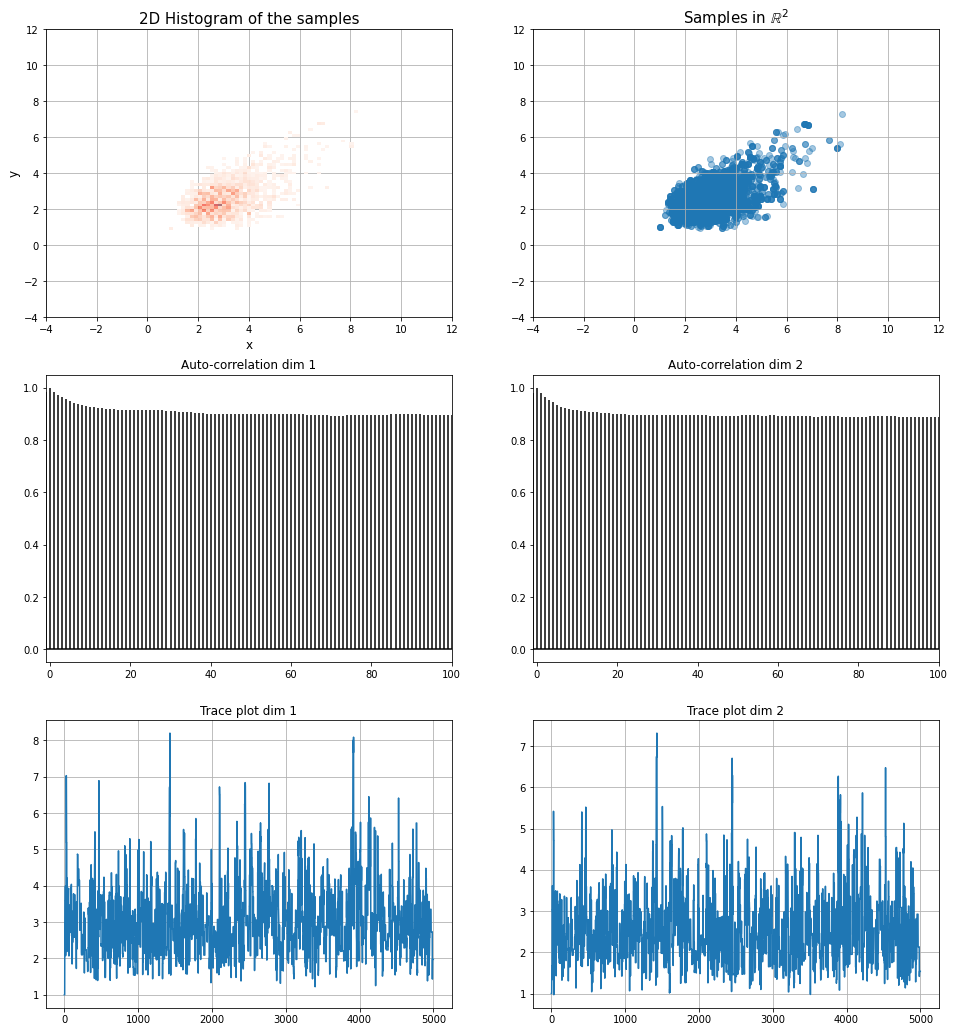

In [33]:
# get the samples
xlim, ylim = (-4, 12), (-4, 12)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, 0], samples[:, 1], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,0], samples[:,1], alpha=.4)
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,0], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,1], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,0])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,1])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()

Comme prévu, on observe un **échantillonnage plus efficace** en termes d'auto-corrélation et de trace-plots: les échantillons sont un peu moins corrélés que précédemment et les trace-plots ne présentent pas de tendance globale.

En termes de parcours du **support de la distribution**, il semble que l'adaptive symetric random walk parcourt celui-ci de façon **plus uniforme**, i.e on n'observe **pas de "trous"** dans l'**histogramme** 2D des échantillons comme c'était le cas avec la SGLD et cet histogramme ressemble fortement aux contour plot de la posterior. 

#### 2.3.2. Distribution prédictive et prédictions

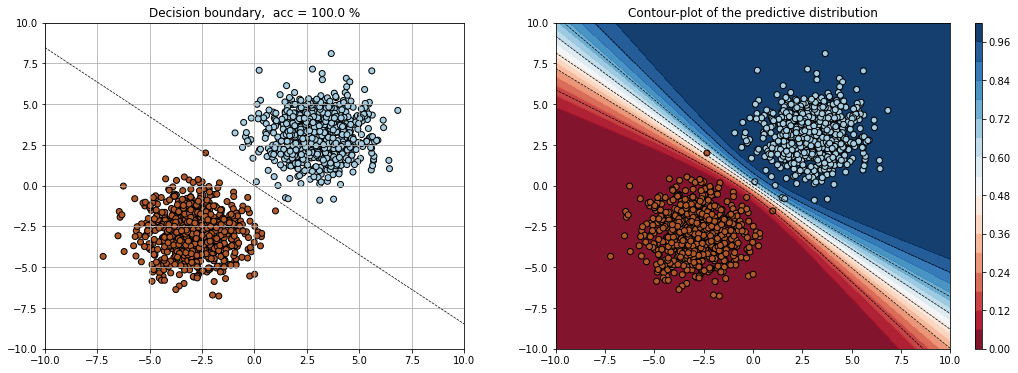

In [34]:
# approximation of the acuracy 
beta = samples[-1]
acc = 100 * (np.sign(X @ beta) == y).mean()

# contour of the predictive distribution
xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = predictive_MC(X_new=zz, samples=samples)
ZZ = ZZ.reshape(xx.shape)

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[.5])
ax[0].set_ylim(-10, 10)
ax[0].set_xlim(-10, 10)
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

On observe des résultats **très similaires** avec ceux obtenus pour la **SGLD**.

### 2.4 Application sur des donées synthétiques (non linéairement séparables)

On utilise ici le même dataset non linéairement spérable que précedemment, où l'on envoie les features de $\mathbb{R}^2$ dans $\mathbb{R}^{10}$ afin d'effectuer la classififcation.

In [35]:
# make sure we manipulate the good datset
X, y = make_moons(n_samples=1500, noise=.09) 
x1, y1 = multivariate_normal.rvs(mean=[1.7,1], cov=.03*np.eye(2), size=150), np.zeros(150)
x2, y2 = multivariate_normal.rvs(mean=[-.5,-.5], cov=.01*np.eye(2), size=150), np.zeros(150)
X = np.concatenate((X, x1, x2), axis=0)
y = np.concatenate((y, y1, y2), axis=0)
y = 2 * y - 1
poly = PolynomialFeatures(3, include_bias=True)
phi_X = poly.fit_transform(X)

print(f"Number of dimension of the new covariates: {phi_X.shape[1]}.")

Number of dimension of the new covariates: 10.


#### 2.4.1. Application

In [36]:
# target distribution
log_target = lambda beta: log_post_laplace(beta, phi_X, y)

# run a SGLD to reinject last sample
a = .6
b = 50
gamma = .7
batch_size = 10
beta_0 = np.ones(phi_X.shape[1])
n_iter = 5000
print("SGLD (for initaialization) :")
time.sleep(.5) # avoid some printing issue
betas = SGLD_logreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size)

# choose adaptive srwmh parameters
dim = phi_X.shape[1]
n_samples = 5000
init_cov =  1 * np.eye(dim)
init_mu = betas[-100:].mean(0)
init_sample = betas[-1]
gamma = .6
print("\nAdaptive symmetric random walk :")
time.sleep(.5)
betas, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, log_target=log_target, dim=dim, reg=1e-5)
print("Acceptance ratio: {}".format(accept_ratio))

SGLD (for initaialization) :


100%|██████████| 5000/5000 [00:00<00:00, 5292.86it/s]


Done in 0.95 s.

Adaptive symmetric random walk :


100%|██████████| 5000/5000 [00:02<00:00, 1732.94it/s]


Done in 2.89 s.
Acceptance ratio: 0.3448


On peut noter la différence en terme de **temps d'exécution**: la **SGLD** est **3 fois plus rapide** que l'adpative symmetric random walk. 

#### 2.4.2. Distribution prédictive et prédictions

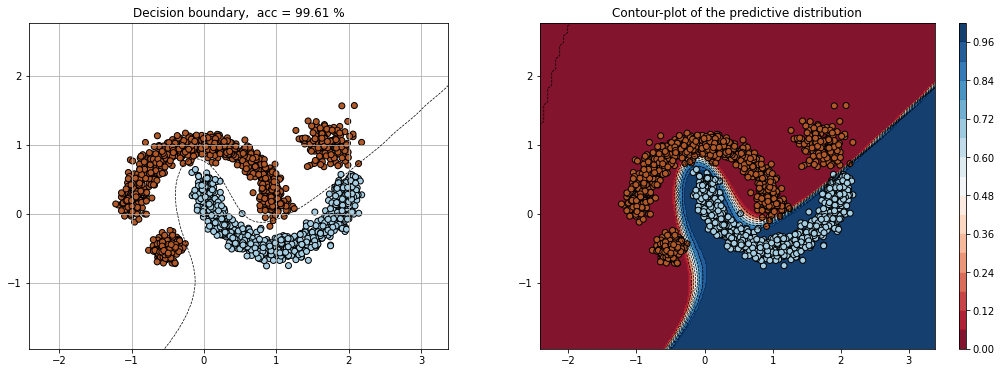

In [37]:
# approximation of the accuracy
beta = betas[-1000:].mean(0)
acc = 100 * (np.sign(phi_X @ beta) == y).mean()

xlim, ylim = (X[:,0].min()-1.2, X[:,0].max()+1.2), (X[:,1].min()-1.2, X[:,1].max()+1.2)

# contour of the predictive distribution
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
phi_zz = poly.fit_transform(zz)
ZZ = predictive_MC(X_new=phi_zz, samples=betas, burn_in=burn_in, weights=trackW)
ZZ = ZZ.reshape(xx.shape).T

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
#x = np.linspace(-10, 10, 10)
#ax[0].plot(x, f(x), linestyle='--', color='k')
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[0.5])
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

On observe des **résultats assez similaires**, à ce que l'on avait avec la **SGLD**, notamment la même erreur de classififcation. En revanche, les courbes de sous niveaux de la distribution prédictive témoigne d'une **incertitude plus faible**, même lorsque l'on s'éloigne des données d'entrainement.

### 2.5 Application sur des données réelles

On utilise le même datatset que celui utilisé precedemment, c'est à dire le dataset avec **17,898 échantillons**, chacun ayant **8 attributs** (features) et une classe binaire (stable, unstable).   
On conserve également les même training set et testings set pré-traités.

In [38]:
# make sure the data is scaled
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### 2.5.1. Application

In [39]:
# target distribution
log_target = lambda beta: log_post_laplace(beta, X_train, y_train)

# perfrom SGLD to get initialization quantities
a = .01
b = 30
gamma = .7
batch_size = 10
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000
print("SGLD:")
time.sleep(.5)
betas = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)

time.sleep(.5) # avoid some printing issue 
dim = X_train.shape[1]
n_samples = 5000
init_mu = betas[-100:].mean(0)
init_cov =  1e-1 * np.eye(dim)
init_sample = betas[-1]  # re-inject last sample in the next run
gamma = .6
print("\nAdaptive symmetric random walk :")
time.sleep(.5)
samples, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, dim=dim, log_target=log_target, reg=1e-6)
print("Acceptance ratio: {}".format(accept_ratio))

SGLD:


100%|██████████| 5000/5000 [00:00<00:00, 5516.13it/s]


Done in 0.91 s.

Adaptive symmetric random walk :


100%|██████████| 5000/5000 [00:04<00:00, 1041.72it/s]


Done in 4.8 s.
Acceptance ratio: 0.3936


On observe une nouvelle fois la rapidité de la **SGLD**, qui est **4 fois plus rapide** que l'**adaptive symmetric random walk**.  

On voit donc que lorsque l'on manipule des **données réelles**, l'**efficacité** de la **SGLD** est **d'autant plus grande**. Ceci montre bien en quoi il est astucieux et efficace de traiter les données par batch.

#### 2.5.2. Predictions et courbes de score de classififcation

In [40]:
# get a point estimates of the parameter (naive strategy : mean of the last 1000 samples)
beta = betas[-1000:].mean(0)

# get the accuracy on the training set
acc_train = 100 * (np.sign(X_train @ beta) == y_train).mean()
print(f"Accuracy on the training set: {round(acc_train, 2)}%")

# get the accuracy on the testing set
acc_test = 100 * (np.sign(X_test @ beta) == y_test).mean()
print(f"Accuracy on the testing set: {round(acc_test, 2)}%")

Accuracy on the training set: 96.71%
Accuracy on the testing set: 96.8%


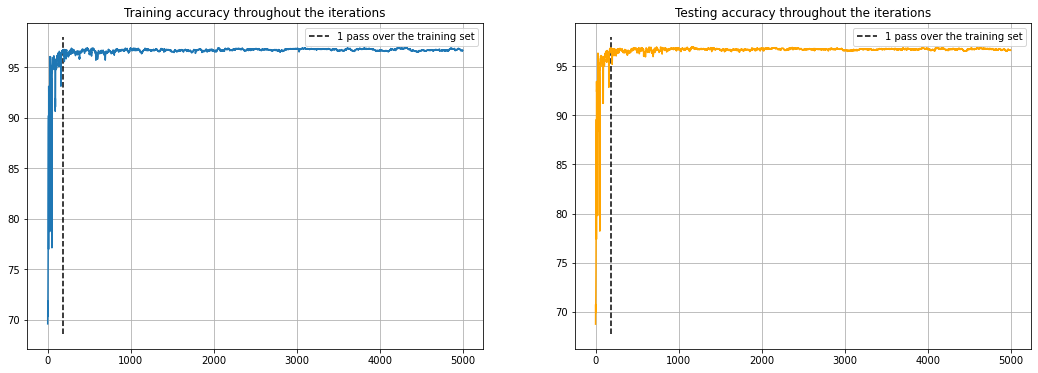

In [41]:
# get the training accuracy at each iteration 
accs_train = get_acc_iter(X_train, y_train, samples=betas)

# get the testing accuracy at each iteration 
accs_test = get_acc_iter(X_test, y_test, samples=betas)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=accs_train.min()-1, ymax=accs_train.max()+1, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(accs_train)
ax[0].set_title("Training accuracy throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=accs_test.min()-1, ymax=accs_train.max()+1, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(accs_test, c='orange')
ax[1].set_title("Testing accuracy throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

On observe une **accuracy beaucoup plus stable** au cours des itérations, on visualise donc le fait que la **SGLD paie le prix de sa rapidité** par une **plus grande variance** dans l'échantillonnage. Moralement, comme la SGLD est un symmetric random walk où l'on accepte le candidat à chaque itération, ce constat est cohérent.

#### 2.5.4. Moyennes et écart type des performances sur 30 exécutions de l'algorithme

Comme précédemment, moyennons ces résultats sur 30 exécutions afin d'avoir une meilleure estimation des performances.

In [42]:
# target distribution
log_target = lambda beta: log_post_laplace(beta, X_train, y_train)


# perfrom SGLD to get initialization quantities
a = .01
b = 30
gamma = .7
batch_size = 10
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000
print(f"SGLD (initialization):")
time.sleep(1) # avoid some printing issue
betas = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)


# set srwmh parameters
dim = X_train.shape[1]
n_samples = 5000
init_mu = betas[-100:].mean(0)
init_cov =  1e-1 * np.eye(dim)
init_sample = betas[-1]  # re-inject last sample in the next run
gamma = .6
time.sleep(.5) # avoid some printing issue

    
# multiple runs 
n_avg = 30
mult_samples = np.zeros((n_avg, n_samples+1, dim))
seedValues = np.random.randint(1000000, size=n_avg)
for ii in range(n_avg):
    np.random.seed(seedValues[ii]) 
    print(f"\nStep {ii+1}: in progress...")
    time.sleep(.5) # avoid some printing issue
    samples, accept_ratio, alphas = adaptive_srwMH(n_samples, init_mu, init_cov, init_sample, gamma, dim=dim, log_target=log_target, reg=1e-6)
    mult_samples[ii] = samples
    print("Acceptance ratio: {}.".format(accept_ratio))
    time.sleep(.5) # avoid some printing issue

SGLD (initialization):


100%|██████████| 5000/5000 [00:00<00:00, 5488.30it/s]


Done in 0.91 s.

Step 1: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1004.54it/s]


Done in 4.98 s.
Acceptance ratio: 0.3898.

Step 2: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1011.68it/s]


Done in 4.94 s.
Acceptance ratio: 0.3816.

Step 3: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1019.06it/s]


Done in 4.91 s.
Acceptance ratio: 0.3784.

Step 4: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1083.06it/s]


Done in 4.62 s.
Acceptance ratio: 0.3812.

Step 5: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1084.00it/s]


Done in 4.62 s.
Acceptance ratio: 0.3808.

Step 6: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1080.92it/s]


Done in 4.63 s.
Acceptance ratio: 0.3642.

Step 7: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1077.09it/s]


Done in 4.64 s.
Acceptance ratio: 0.3932.

Step 8: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1091.16it/s]


Done in 4.59 s.
Acceptance ratio: 0.3802.

Step 9: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1083.17it/s]


Done in 4.62 s.
Acceptance ratio: 0.392.

Step 10: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1084.34it/s]


Done in 4.61 s.
Acceptance ratio: 0.3826.

Step 11: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1064.85it/s]


Done in 4.7 s.
Acceptance ratio: 0.3778.

Step 12: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1091.28it/s]


Done in 4.58 s.
Acceptance ratio: 0.3974.

Step 13: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1047.05it/s]


Done in 4.78 s.
Acceptance ratio: 0.3868.

Step 14: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1014.21it/s]


Done in 4.93 s.
Acceptance ratio: 0.3984.

Step 15: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1024.59it/s]


Done in 4.88 s.
Acceptance ratio: 0.3864.

Step 16: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1007.17it/s]


Done in 4.97 s.
Acceptance ratio: 0.3924.

Step 17: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1078.62it/s]


Done in 4.64 s.
Acceptance ratio: 0.3882.

Step 18: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1074.48it/s]


Done in 4.66 s.
Acceptance ratio: 0.3946.

Step 19: in progress...


100%|██████████| 5000/5000 [00:05<00:00, 899.56it/s] 


Done in 5.56 s.
Acceptance ratio: 0.3828.

Step 20: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1094.81it/s]


Done in 4.57 s.
Acceptance ratio: 0.3934.

Step 21: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1066.55it/s]


Done in 4.69 s.
Acceptance ratio: 0.3924.

Step 22: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1053.66it/s]


Done in 4.75 s.
Acceptance ratio: 0.3916.

Step 23: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1102.27it/s]


Done in 4.54 s.
Acceptance ratio: 0.396.

Step 24: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1075.11it/s]


Done in 4.65 s.
Acceptance ratio: 0.3892.

Step 25: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1014.25it/s]


Done in 4.93 s.
Acceptance ratio: 0.3968.

Step 26: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1073.36it/s]


Done in 4.66 s.
Acceptance ratio: 0.3866.

Step 27: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1084.55it/s]


Done in 4.61 s.
Acceptance ratio: 0.3814.

Step 28: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1077.64it/s]


Done in 4.64 s.
Acceptance ratio: 0.3792.

Step 29: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1077.82it/s]


Done in 4.64 s.
Acceptance ratio: 0.3778.

Step 30: in progress...


100%|██████████| 5000/5000 [00:04<00:00, 1022.47it/s]


Done in 4.89 s.
Acceptance ratio: 0.3908.


In [43]:
# get a point estimates of the parameter (naive strategy : mean of the last 1000 samples)
accs_train = np.asarray([100 * (np.sign(X_train @ mult_samples[ii, -1000:, :].mean(0)) == y_train).mean() for ii in range(n_avg)])

# get the accuracy on the training set
print(f"Mean accuracy on the training set over the 30 runs: {round(accs_train.mean(), 2)}%.")
print(f"Std accuracy on the training set over the 30 runs: {round(accs_train.std(), 2)}.")

# get the accuracy on the testing set
accs_test = np.asarray([100 * (np.sign(X_test @ mult_samples[ii, -1000:, :].mean(0)) == y_test).mean() for ii in range(n_avg)])
print(f"\nMean accuracy on the testing set over the 30 runs: {round(accs_test.mean(), 2)}%.")
print(f"Std accuracy on the testing set over the 30 runs: {round(accs_test.std(), 2)}%.")

Mean accuracy on the training set over the 30 runs: 96.68%.
Std accuracy on the training set over the 30 runs: 0.02.

Mean accuracy on the testing set over the 30 runs: 96.79%.
Std accuracy on the testing set over the 30 runs: 0.02%.


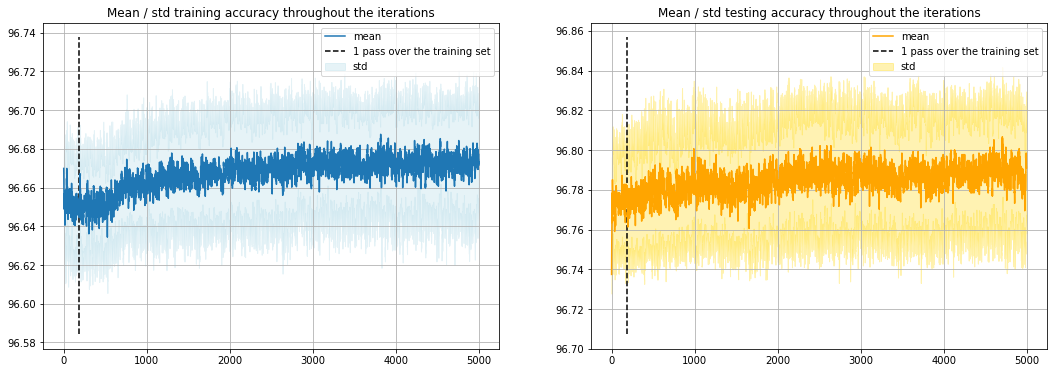

In [44]:
# get the training accuracy at each iteration for each execution of the algorithm
mult_accs_train = np.zeros((n_avg, n_samples))
for ii in range(n_avg):
    mult_accs_train[ii] = get_acc_iter(X_train, y_train, samples=mult_samples[ii])

# get the training accuracy at each iteration for each execution of the algorithm
mult_accs_test = np.zeros((n_avg, n_samples))
for ii in range(n_avg):
    mult_accs_test[ii] = get_acc_iter(X_test, y_test, samples=mult_samples[ii])

# get the training accuracy at each iteration 
mean_train = mult_accs_train.mean(0)
upper_train = mean_train + mult_accs_train.std(0)
lower_train = mean_train - mult_accs_train.std(0)

# get the training accuracy at each iteration 
mean_test = mult_accs_test.mean(0)
upper_test = mean_test + mult_accs_test.std(0)
lower_test = mean_test - mult_accs_test.std(0)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=mean_train.min()-.05, ymax=mean_train.max()+.05, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(mean_train, label='mean')
ax[0].fill_between(np.arange(len(lower_train)), lower_train, upper_train,
                   color='lightblue', alpha=.3, label='std')
ax[0].set_title("Mean / std training accuracy throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=mean_test.min()-.03, ymax=mean_test.max()+.05, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(mean_test, color='orange', label='mean')
ax[1].fill_between(np.arange(len(lower_test)), lower_test, upper_test,
                   color='gold', alpha=.3, label='std')
ax[1].set_title("Mean / std testing accuracy throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

On observe donc que les **résultats** sont **très stables**.  

Nous n'avons **pas de phase d'instabilité** lié à la pahse d'optimisation de la SGLD, mais précisons que l'on a **initialisé** notre algotihme **grâce** à une **éxécution** de **SGLD**. Il semble donc qu'il soit judicieux de réinjecter les résultats d'une exécution de SGLD pour combiner les forces des deux méthodes et avoir un échantillonnage stable et de qualité.

#### 2.5.4. Distribution prédictive et bénéfices des méthodes bayésiennes 

In [45]:
# get predictive distribution for each testing examples
pred_test = predictive_MC(X_new=X_test, samples=betas, burn_in=burn_in, weights=trackW)

# get a hard prediction
y_pred = 2 * (pred_test >= .5) -1

# get misclassified examples
idxs_misclass = np.where(y_pred != y_test)[0]

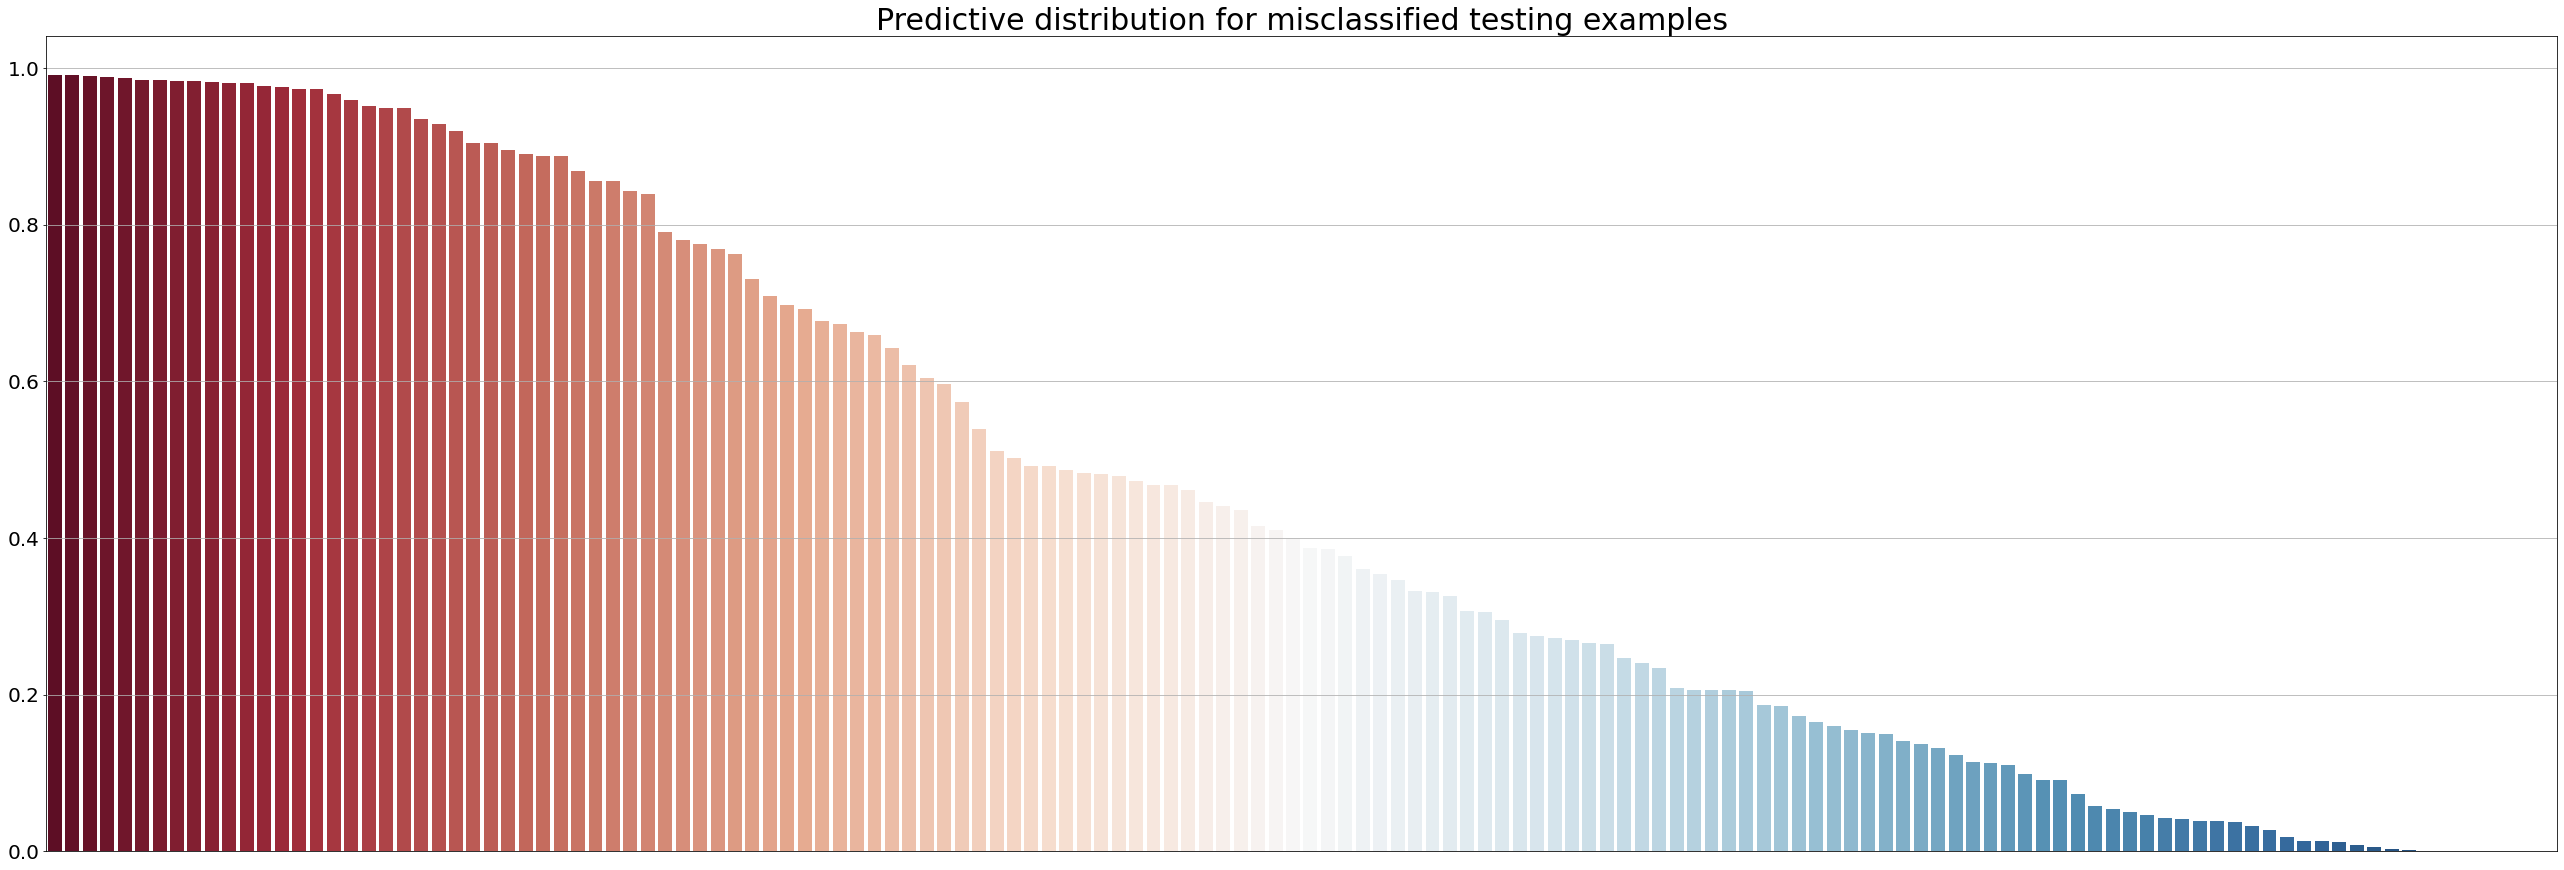

In [46]:
fig, ax = plt.subplots(figsize=(45,15))
bar = sns.barplot(y=np.flip(np.sort(pred_test[idxs_misclass])), 
            x=[str(x) for x in idxs_misclass[np.flip(np.argsort(pred_test[idxs_misclass]))]], 
            palette='RdBu', orient='v', ax=ax);
ax.axes.xaxis.set_ticks([])
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_title("Predictive distribution for misclassified testing examples", fontsize=30)
ax.grid();

Il semblerait que l'**incertitude** sur les prédictions soit légèrement **mieux maitrisée**. En effet, parmi les distributions prédictives des testing examples mal classifiés, on voit moins de distribution prédictive très proches de 1 ou de 0. Calculons alors le critère basé sur l'entropie binaire décrit précédemment afin de comparer la robustesse à celle obtenue précedemment pour la SGLD. 

#### 2.5.5. Un critère de robustesse 

Comme précedemment, nous moyennons les résultats sur les 30 exécutions précédentes de l'algorithme.

In [47]:
# get predictive distribution for each testing examples
preds_test = np.asarray([predictive_MC(X_new=X_test, samples=mult_samples[ii, :, :], burn_in=burn_in, weights=trackW) for ii in range(n_avg)])

# get a hard prediction
y_preds = 2 * (preds_test >= .5) - 1

# get misclassified examples
idxs_misclass = np.asarray([np.where(y_preds[ii] != y_test)[0] for ii in range(n_avg)])

# get robustness criterions 
crits = np.asarray([get_criterion_ent(pred_distrib=preds_test[ii], idxs_misclass=idxs_misclass[ii]) for ii in range(n_avg)])
print(f"Mean robustness criterion: {round(crits.mean(), 5)}.")
print(f"Std robustness criterion: {round(crits.std(), 5)}.")

Mean robustness criterion: 0.52727.
Std robustness criterion: 0.00224.


/Users/louisbouvier/Documents/MVA-MPRO/MVA/S2/Learning/Bayesian Machine Learning/BML_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Le **critère** de **robustesse** es donc **très légèrement plus faible**, avec une diminution de la moyenne de 1% par rapport à la SGLD En revanche, on constate une diminution de la variance de 40%, ce qui montre bien qu'une initialisation avec une SGDL puis une exécution d'un adaptive symmetric random walk stabilise fortme les résultats par rapport à deux exécutions consécutives de SGLD.

## 3. Méthode Hamiltoniennes

### 3.1 Un bref récapitulatif de la méthode

Il semble à présent intéressant de comparer la SGLD aux méthodes Hamiltoniennes MCMC dont la Langevin MCMC fait partie. Nous avons appréhendé cette famille d'approches grâce à l'article didactique de Neal : MCMC using Hamiltonian dynamics, in Brooks, S., Gelman, A., Jones, G., and Meng, X.-L [[Neal, 2011]](https://arxiv.org/abs/1206.1901). 

Sans rentrer dans les détails, nous introduisons les notations et principes majeurs des méthodes Hamiltoniennes.
De manière générale, elles se basent sur la dynamique du même nom pour générer des propositions et constuire une chaîne de Markov. L'idée est de prendre comme position $q$ la variable qui nous intéresse (ici $\beta$ dans la régression logistique). On définit de manière artificielle une quantité de mouvement $p$. Le Hamiltonien est alors une fonction de ces deux variables que l'on prend séparable comme suit:
$$ H(q,p) = U(q) + K(p)$$

Où $U$ peut être comprise par analogie comme une énergie potentielle et $K$ comme une énergie cinétique. On prend alors $K$ sous forme quadratique: 
$$K(p) = p^T M p$$

où $M$ est une matrice de masse.

Pour ce qui est de $U$, l'idée est de choisir l'opposé du log-posterior.

On définit alors une loi jointe sur les variables $(q,p)$ comme suit:

$$ p(q,p) = \frac {1}{Z} exp\bigg(-(U(q)+K(p))\bigg)$$


On peut alors itérer en alternant:
- une phase d'échantillonnage de $p$ selon la loi Gaussienne définie naturellement par $p(p) \propto exp(-K(p))$, indépendamment de la position $q$. On voit que **ce choix d'énergie cinétique quadratique induit naturellement une variable Gaussienne** que l'on injecte dans le modèle, notamment décrit au dessus pour la SGLD.
- une phase d'échantillonnage de type Metropolis-Hastings, où la proposition est calculée par simulation de la dynamique Hamiltonienne sur un horizon fixé en partant des valeurs courantes de la position et de la quantité de mouvement en conditions initiales. Une discrétisation temporelle est opérée (pas de temps $\epsilon$, horizon $T=L \times \epsilon$), et un schéma d'intégration est mis en place. Cette dynamique est donnée par:

$$ \frac{dq}{dt} = \frac{\partial H}{\partial p}$$
$$ \frac{dp}{dt} = -\frac{\partial H}{\partial q}$$


La méthode de Langevin est un cas particulier où le nombre de pas de temps simulés est égal à $1$: $L=1$. La matrice de masse est de plus prise diagonale égale à l'identité dans l'article. Les échantillonneurs tels que NUTS de Pymc proposent une matrice de masse diagonale avec des poids adaptés automatiquement aux données.

Notons qu'une température $T$ est parfois introduite, dans ce cas:
$$ p(q,p) = \frac {1}{Z} exp\bigg(-\frac{(U(q)+K(p))}{T}\bigg)$$


### 3.2 Implementation 

In [48]:
def leapfrog_step(batch_X, batch_y, p, q, eps, mass_matrix, N):
    """
    The leapfrog integration method that preserves volume and is reversible
    Inputs:
        - batch_X (np.array): batch of training examples 
        - batch_y (np.array): batch of corresponding labels
        - q (np.array): the position variable (variable of interest) at step t
        - p (np.array): the momentum variable (artificial variable) at step t
        - eps (float): the value of the step size
        - mass_matrix (np.array): the mass matrix of the kinetic energy
        - N (int): total amount of samples in the data set
    Outputs:
        - q_new (np.array): the position variable (variable of interest) at step t+eps
        - p_new (np.array): the momentum variable (artificial variable) at step t+eps
    """
    grad_q = -gradient_laplace(q, batch_X, batch_y, n_samples=N)#gradient of - log posterior (U)
    p_mid = p - eps/2 * grad_q
    q_new = q + eps*mass_matrix@p_mid
    grad_q_new = -gradient_laplace(q_new, batch_X, batch_y, n_samples=N)#gradient of - log posterior (U)
    p_new = p_mid - eps/2 * grad_q_new
    return q_new, p_new

In [49]:
def Hamiltonian_dynamic(batch_X, batch_y, p, q, eps, mass_matrix, L, N):
    """
    A function to simulate langevin dynamics with H(q,p) = U(q)+K(p) and K quadratic in p with mass_matrix
    Inputs:
        - batch_X (np.array): batch of training examples 
        - batch_y (np.array): batch of corresponding labels
        - q (np.array): the position variable (variable of interest) at step t
        - p (np.array): the momentum variable (artificial variable) at step t
        - eps (float): the value of the step size
        - L (integer): the amount of time steps the simulation has to last
        - mass_matrix (np.array): the mass matrix of the kinetic energy
        - N (int): total amount of samples in the data set

    Output:
        - q_prop (np.array): a proposal for the variable q
        - p_prop (np.array): a proposal for the fictive variable p
    """
    p_step, q_step = p.copy(), q.copy()
    for step in range(L):
        q_step, p_step = leapfrog_step(batch_X, batch_y, p_step, q_step, eps, mass_matrix, N)
    return q_step, p_step

In [50]:
def compute_hamiltonian(batch_X, batch_y, p, q, mass_matrix):
    """
    A function to compute the value of the Hamiltonian at a given point (q,p)
    Inputs:
        - batch_X (np.array): batch of training examples 
        - batch_y (np.array): batch of corresponding labels
        - q (np.array): the position variable (variable of interest) 
        - p (np.array): the momentum variable (artificial variable) 
        - mass_matrix (np.array): the mass matrix of the kinetic energy
    Output:
        -H(q,p) (float): the value of the Hamiltonian at point (q,p) with likelihood computed over (batch_X, batch_y)
    """
    return -log_post_laplace(q, batch_X, batch_y) + p.T@mass_matrix@p

Une fois les fonctions de base définies - pour calculer la valeur du Hamiltonien en un point caractérisé par la position $q$ et la quantité de mouvement $p$ $H(q,p)$, une étape d'intégration de la dynamique Hamiltonienne **conservant le volume et réversible** (méthode leapfrog) et une simulation de la dynamique Hamiltonienne discrétisée sur un nombre fixé d'étapes - nous pouvons construire une fonction d'échantillonnage.

Cette dernière utilise les deux étapes définies à la sous section précédente (en n'oubliant pas la négation de la quantité de mouvement), incluant une proposition de type Metropolis-Hastings qui dépend des valeurs du Hamiltonien. 

Afin de rendre possible une forme d'extension du SGLD (comme les méthodes Hamiltoniennes sont des extensions de l'échantillonnage par dynamique de Langevin), nous rendons possible la prise en compte d'un batch au lieu du data set entier pour le calcul de la valeur de la posterior et de son gradient. Dans ce cas, nous acceptons systématiquement les propositions comme dans la SGLD. Nous avons essayé de mettre à l'échelle la matrice de masse ou de la garder constante. La première option se rapproche de l'article sur la SGLD, la seconde paraît empiriquement favoriser une diversité des échantillons et une exploration de l'espace. Nous utilisons comme suggéré dans l'article de Neal une version où la **matrice de masse est prise comme égale à la covariance empirique des échantillons** (calculée sur une phase préliminaire).

Notons que notre **idée ici est d'appréhender la différence entre ces méthodes "à la main"** (l'horizon $L$, le pas $\epsilon$, la matrice de masse) plutôt que de rendre une Stochastic Gradient Hamiltonian Dynamic optimale. Nous avons pris conscience de la quantité de travaux dans cette voie, notamment Stochastic Gradient Hamiltonian Monte Carlo, Tianqi Chen et al. https://arxiv.org/pdf/1402.4102.pdf

In [65]:
def Hamiltonian_MCMC_logreg(X, y, n_iter, a, b, eps, L, mass_matrix, gamma, beta_0, batch_size=X.shape[0], bool_trackW=False, bool_trackL=False, bool_trackA=False):    
    """
    Hamiltonian MCMC for Bayesian Logistic Regression with Laplace Prior.
    When batchs are the entire dataset a Hamiltonian MCMC method is used. 
    When batchs are smaller, we always accept the prior and the steps are decreased as for SGLD
    Arguments:
      X: np.array,  training examples 
      y: np.array, training labels
      n_iter: int, number of iterations
      eps: float, the step size when considered constant
      L: int, the amount of steps in the Hamiltonian dynamics simulation
      mass_matrix: np.array, the artificial mass matrix for the kinetic energy definition
      a: float, plays a role of learning rate
      b: float, controls the learning rate decay for the first iterations
      gamma: float in (.5, 1], controls step size decay
      beta_0: np.array, initial beta 
      batch_size: int, size of the batch 
      bool_trackL: boolean, if True compute and return the log-posterior at each step (costly: require a pass over the whole training set)
      bool_weights: boolean, if True return the weights at each iteration to compute posterior expectation (as proposed in the article)
    Return:
      tackL: np.array, log-posterior evaluate at each step
      betas: np.array, paremeters at each step
      acceptance_rate: the acceptance rate of the sampling method
      alphas: np.array, acceptance probability at each step
    """  
    start = time.time()
    N, dim = X.shape
    beta = beta_0
    p = multivariate_normal.rvs(mean=np.zeros(dim), cov=mass_matrix)
    betas = np.concatenate((beta[None,:], np.zeros((n_iter, dim))), axis=0)
    ps = np.concatenate((p[None,:], np.zeros((n_iter, dim))), axis=0)
    accept_bools = np.zeros(n_iter)
    alphas = np.zeros(n_iter)

    
    # compute and store log-posterior throughout the iterations if required
    if bool_trackL: 
        trackL = np.concatenate(([log_post_laplace(beta, X, y)], np.zeros(n_iter)))
        
    # store weights throughout the iterations if required
    if bool_trackW:
        trackW = np.zeros(n_iter)
        
    
    for ii in tqdm(range(n_iter)):
                
        # select a batch of size batch_size
        idxs = np.random.choice(N, size=batch_size)
        batch_X = X[idxs]
        batch_y = y[idxs]
        
        ### STEP 1: ###
        # compute step size
        if batch_size < N:
            step_size = get_step_size(a, b, gamma, t=ii)
        else:    
            step_size = eps
        
        ### STEP 2: ###
        # sample the momentum
        if batch_size < N:
            p = multivariate_normal.rvs(mean=np.zeros(dim), cov=mass_matrix)
        else:
            p = multivariate_normal.rvs(mean=np.zeros(dim), cov=mass_matrix)
        
        ### STEP 3: ###
        # compute a proposal
        if batch_size < N:
            beta_prop, p_prop = Hamiltonian_dynamic(batch_X, batch_y, p, beta, eps, mass_matrix, L, N)
        else:
            beta_prop, p_prop = Hamiltonian_dynamic(batch_X, batch_y, p, beta, eps, mass_matrix, L, N)
            
        p_prop = - p_prop #negate p for symmetry, see Neal for details
        
        ### STP 4:###
        # update with Metropolis Hastings rule
        H_pq = compute_hamiltonian(batch_X, batch_y, p, beta, mass_matrix)
        H_pq_prop = compute_hamiltonian(batch_X, batch_y, p_prop, beta_prop, mass_matrix)
        log_proba_accept = min(0, -H_pq_prop+H_pq)
        alphas[ii] = np.exp(log_proba_accept)
        accept_bools[ii] = np.log(np.random.rand()) < log_proba_accept

        if accept_bools[ii] or batch_size<N:
            beta, p = beta_prop, p_prop
        
        ### STEP 5: ###
        # store parameters
        betas[ii+1] = beta
        
        # compute and store log-posterior if required
        if bool_trackL:
            trackL[ii+1] = log_post_laplace(beta, X, y)
            
        # store weights if required
        if bool_trackW:
            trackW[ii] = step_size
    
    acceptance_rate = np.mean(accept_bools.astype('int'))
    end = time.time()
    time.sleep(.1)
    print(f"Done in {round(end-start, 2)} s.")
    
    if  bool_trackW & bool_trackL:
        return betas, trackW, trackL, acceptance_rate, alphas
    if  bool_trackW: 
        return betas, trackW, acceptance_rate, alphas
    if  bool_trackL: 
        return betas, trackL, alphas
    if bool_trackW & bool_trackW: 
        return betas, trackW, trackL, acceptance_rate, alphas
    if bool_trackW:
        return betas, trackW, acceptance_rate, alphas
    if bool_trackL:
        return betas, trackL, acceptance_rate, alphas
    else:
        return betas,acceptance_rate, alphas

In [66]:
def get_init_from_SGLD(samples,last_steps=100):
    """
    inputs:
    - samples: np.array, samples from the SGLD (beta parameters)
    - last_steps: integer, the amount of last steps to compute a mean as initial point
    outputs:
    - emp_cv: np.array, the empirical covariance of the samples
    - beta_init: np.array, a point to initialise a sampling method"""
    mean_last_steps = np.mean(samples[-last_steps:,:],axis=0).reshape(1,-1,)
    return 1/(last_steps-1) * (samples[-last_steps:,:]-mean_last_steps).T@(samples[-last_steps:,:]-mean_last_steps), mean_last_steps

Dans les sous-sections qui suivent, nous lançons des échantillonnages avec différents paramètres pour expérimenter leur influence ($L$, $\epsilon$) et le type de méthode (étape Metropolis-Hastings sur le data set entier ou gradient stochastique sur des batchs en acceptant systématiquement). Etant donnée **l'amplitude possible des paramètres** et la **durée des simulations**, nous ne procédons pas à une moyenne comme précédemment.

### 3.3 Application sur des données synthétiques (linéairement séparables) 

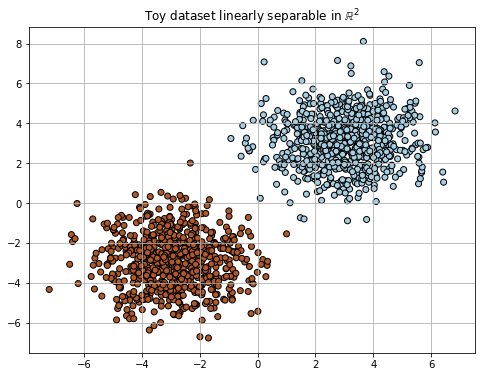

In [68]:
# load linearly separable dataset
X, y = make_blobs(n_samples=1500, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

# visualize dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Paired_r', edgecolors='k')
plt.title("Toy dataset linearly separable in $\mathbb{R}^2$")
plt.grid()
plt.show()

In [69]:
a = 1
b = 20
gamma = .6
batch_size = 5
beta_0 = np.random.rand(X.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_logreg(X, y, n_iter, a, b, gamma, beta_0, batch_size)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:01<00:00, 4963.90it/s]


Done in 1.01 s.


In [70]:
cov, point_init = get_init_from_SGLD(betas)

In [71]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, X, y))

N, dim = X.shape
n_iter = 5000
mass_matrix =  cov # we set the mass matrix as the empirical covariance (see Neal for some details)
beta_0 = np.ones(dim)#point_init[0]
a = .1
b = 40
gamma = .7
eps = 0.5
L=100

samples, accept_ratio, alphas = Hamiltonian_MCMC_logreg(X, y, n_iter, a, b, eps, L, mass_matrix, gamma, 
                                                        beta_0, batch_size=N, bool_trackW=False, 
                                                        bool_trackL=False, bool_trackA=False)    
print("Acceptance ratio: {}".format(accept_ratio))

100%|██████████| 5000/5000 [00:58<00:00, 85.45it/s]


Done in 58.52 s.
Acceptance ratio: 0.693


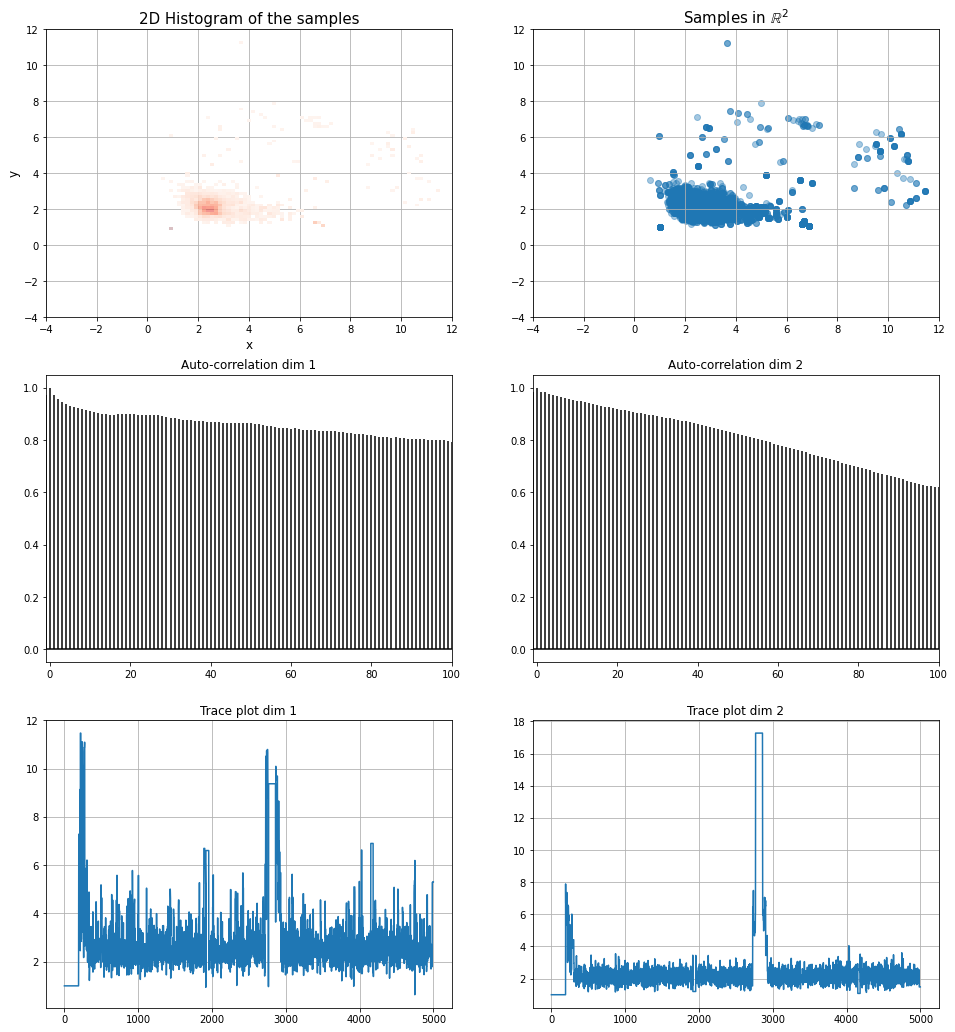

In [72]:
# get the samples
xlim, ylim = (-4, 12), (-4, 12)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, 0], samples[:, 1], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,0], samples[:,1], alpha=.4)
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,0], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,1], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,0])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,1])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()

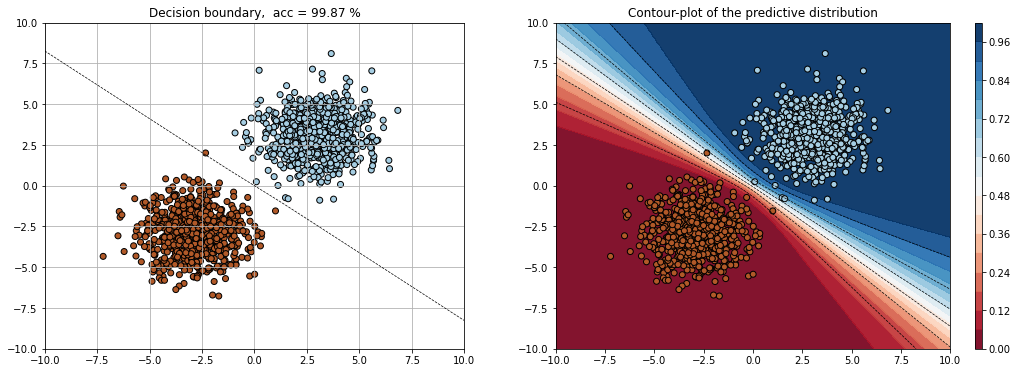

In [73]:
# approximation of the acuracy 
beta = samples[-1]
acc = 100 * (np.sign(X @ beta) == y).mean()

# contour of the predictive distribution
xs = np.linspace(-10, 10, 100)
ys = np.linspace(-10, 10, 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
ZZ = predictive_MC(X_new=zz, samples=samples)
ZZ = ZZ.reshape(xx.shape)

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[.5])
ax[0].set_ylim(-10, 10)
ax[0].set_xlim(-10, 10)
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

Nous avons lancé ici un échantillonnage de type Hamiltonian MCMC avec une étape MH. Nous voyons que la **durée n'a rien à voir avec celle de SGLD** à cause des étapes de simulation de la dynamique discrétisée et de l'étape MH. Nous voyons encore l'intérêt sur ce point de la SGLD, qui avait d'ailleurs une meilleure précision relativement aux paramètres choisis ici

### 3.4 Application sur des donées synthétiques (non linéairement séparables)

In [74]:
# make sure we manipulate the good datset
X, y = make_moons(n_samples=1500, noise=.09)
x1, y1 = multivariate_normal.rvs(mean=[1.7,1], cov=.03*np.eye(2), size=150), np.zeros(150)
x2, y2 = multivariate_normal.rvs(mean=[-.5,-.5], cov=.01*np.eye(2), size=150), np.zeros(150)
X = np.concatenate((X, x1, x2), axis=0)
y = np.concatenate((y, y1, y2), axis=0)
y = 2 * y - 1
poly = PolynomialFeatures(3)
phi_X = poly.fit_transform(X)

In [75]:
a = .1
b = 40
gamma = .7
batch_size = 10
beta_0 = np.ones(phi_X.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxilliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas = SGLD_logreg(phi_X, y, n_iter, a, b, gamma, beta_0, batch_size)

Without computing any auxilliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 5814.60it/s]


Done in 0.86 s.


In [76]:
cov, point_init = get_init_from_SGLD(betas)

In [77]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, phi_X, y))

N, dim = phi_X.shape
n_iter = 5000
mass_matrix = cov
beta_0 = np.ones(dim)#point_init[0]
a = .1
b = 40
gamma = .7
eps = 0.1
L=50

samples, accept_ratio, alphas = Hamiltonian_MCMC_logreg(phi_X, y, n_iter, a, b, eps, L, mass_matrix, gamma, 
                                                        beta_0, batch_size=N//10, bool_trackW=False, 
                                                        bool_trackL=False, bool_trackA=False)    
print("Acceptance ratio: {}".format(accept_ratio))

100%|██████████| 5000/5000 [00:13<00:00, 368.32it/s]


Done in 13.58 s.
Acceptance ratio: 0.0858


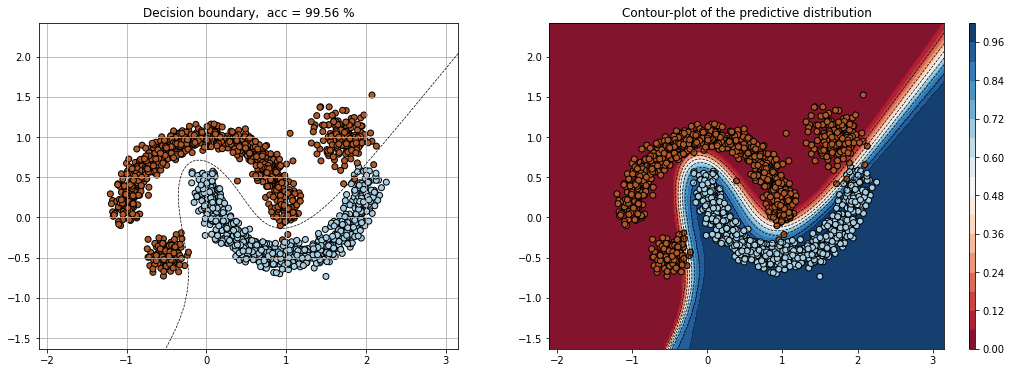

In [78]:
# approximation of the accuracy
beta = samples[-1]
acc = 100 * (np.sign(phi_X @ beta) == y).mean()

xlim, ylim = (X[:,0].min()-.9, X[:,0].max()+.9), (X[:,1].min()-.9, X[:,1].max()+.9)

# contour of the predictive distribution
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(xs, ys, sparse=False, indexing='ij')
zz = np.array([[xss,yss] for (xss,yss) in zip(xx.ravel(), yy.ravel())])
phi_zz = poly.transform(zz)
ZZ = predictive_MC(X_new=phi_zz, samples=samples, burn_in=100)
ZZ = ZZ.reshape(xx.shape).T

#fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = plt.subplots(1, 2, figsize=(2*9, 6), gridspec_kw={"width_ratios": [.85, 1]})

# visualize decision boundary 
ax[0].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
#x = np.linspace(-10, 10, 10)
#ax[0].plot(x, f(x), linestyle='--', color='k')
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7, levels=[0.5])
ax[0].set_title("Decision boundary, "+" acc = {} %".format(round(acc, 2)))
ax[0].grid()

# contour of the predictive distribution
cont = ax[1].contourf(xs, ys, ZZ, 18, cmap='RdBu',
            vmin=ZZ.min(), vmax=ZZ.max(), alpha=.95)
fig.colorbar(cont, aspect=50)
ax[1].contour(xs, ys, ZZ, colors='k', linestyles='--', linewidths=0.7)
ax[1].scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
ax[1].set_title("Contour-plot of the predictive distribution");

plt.show()

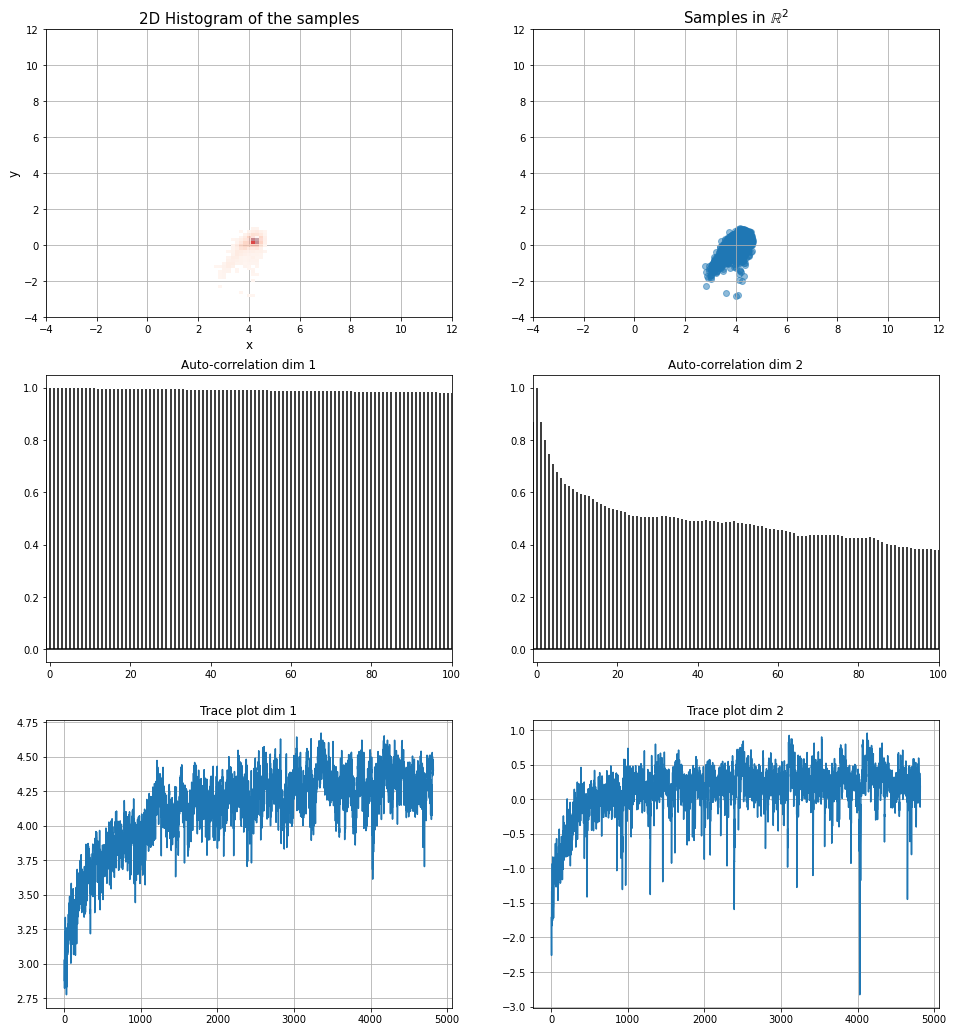

In [79]:
dim_plot_1 = 0
dim_plot_2 = 2
# get the samples
burn_in = int(num_epoch*num_samples/batch_size)
samples = samples[burn_in:]
xlim, ylim = (-4, 12), (-4, 12)

# get 2-D histogram of the samples
xs = np.linspace(xlim[0], xlim[1], 100)
ys = np.linspace(ylim[0], ylim[1], 100)
H, xs, ys = np.histogram2d(samples[:, dim_plot_1], samples[:, dim_plot_2], bins=(xs, ys))
H = H.T

fig, ax = plt.subplots(3, 2, figsize=(2*8, 3*6))
ax = ax.ravel()

ax[0].imshow(H, interpolation='nearest', origin='lower',
                   extent=[xs[0], xs[-1], ys[0], ys[-1]],
                   cmap="Reds", vmin=0., alpha=H, zorder=10, aspect='auto')
ax[0].grid()
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_title('2D Histogram of the samples', fontsize=15)

ax[1].scatter(samples[:,dim_plot_1], samples[:,dim_plot_2], alpha=.5)
ax[1].set_title('Samples in $\mathbb{R}^2$', fontsize=15)
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()

# auto-correlation plot dim 1
ax[2].acorr(samples[:,dim_plot_1], maxlags=100, color='k')
ax[2].set_xlim(-1,100)
ax[2].set_title("Auto-correlation dim 1")

# auto-correlation plot dim 2
ax[3].acorr(samples[:,dim_plot_2], maxlags=100, color='k')
ax[3].set_xlim(-1,100)
ax[3].set_title("Auto-correlation dim 2")

# traceplot dim 1
ax[4].plot(np.arange(len(samples)), samples[:,dim_plot_1])
ax[4].set_title("Trace plot dim 1")
ax[4].grid()

# traceplot dim 2
ax[5].plot(np.arange(len(samples)), samples[:,dim_plot_2])
ax[5].set_title("Trace plot dim 2")
ax[5].grid()

plt.show()

Pour cet exemple, nous avons étudié une forme de **variante de la SGLD** en simulant sur $L=50$ étapes une dynamique Hamiltonienne avec des **estimations par batchs** et une **acceptation systématique**. Nous voyons que puisque nous n'avons pas mis à l'échelle la matrice de masse ici au fil des itérations, les trace plots montrent de grandes variations. Cela est effectué pour permettre de trouver plus facilement l'optimum local rencontré en partant d'un point arbitraire. La durée de la simulation n'a encore rien à voir avec la méthode SGLD. 

### 3.5 Application sur des données réelles

In [100]:
# pre-process data
X_ = data[data.columns[:-1]].values

# pre-process labels
y_ = 2 * (data[data.columns[-1]]==0).values - 1

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=.25, random_state=42)

print(f"Number of training examples: {len(X_train)}.")
print(f"Number of testing examples: {len(X_test)}.")

Number of training examples: 13423.
Number of testing examples: 4475.


In [101]:
# fit scaler on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# scale test data
X_test = scaler.transform(X_test)

In [102]:
a = .01
b = 30
gamma = .7
batch_size = 10
beta_0 = np.zeros(X_train.shape[1])
n_iter = 5000

# without computing log-posterior at each step  
print(f"Without computing any auxiliary quantity at each step (no log-posterior, no alpha):")
time.sleep(1)
betas_SGLD = SGLD_logreg(X_train, y_train, n_iter, a, b, gamma, beta_0, batch_size)

Without computing any auxiliary quantity at each step (no log-posterior, no alpha):


100%|██████████| 5000/5000 [00:00<00:00, 5373.25it/s]


Done in 0.93 s.


In [103]:
cov, point_init = get_init_from_SGLD(betas_SGLD)

In [104]:
# target distribution
target = lambda beta: np.exp(log_post_laplace(beta, X_train, y_train))

N, dim = X_train.shape
n_iter = 5000
mass_matrix =  cov
beta_0 = np.ones(dim)#point_init[0]
a = .1
b = 40
gamma = .7
eps = 0.1
L=50

samples, accept_ratio, alphas = Hamiltonian_MCMC_logreg(X_train, y_train, n_iter, a, b, eps, L, mass_matrix, gamma, 
                                                        beta_0, batch_size=N//20, bool_trackW=False, 
                                                        bool_trackL=False, bool_trackA=False)    
print("Acceptance ratio: {}".format(accept_ratio))

100%|██████████| 5000/5000 [00:24<00:00, 201.59it/s]


Done in 24.81 s.
Acceptance ratio: 0.0


In [95]:
# get a point estimates of the parameter (naive strategy)
beta = samples[-1]
burn_in = int(num_epoch*num_samples/batch_size)

# get the accuracy on the training set
acc_train = 100 * (np.sign(X_train @ beta) == y_train).mean()
print(f"Accuracy on the training set: {round(acc_train, 2)}%")

# get the accuracy on the testing set
acc_test = 100 * (np.sign(X_test @ beta) == y_test).mean()
print(f"Accuracy on the testing set: {round(acc_test, 2)}%")

Accuracy on the training set: 96.49%
Accuracy on the testing set: 96.56%


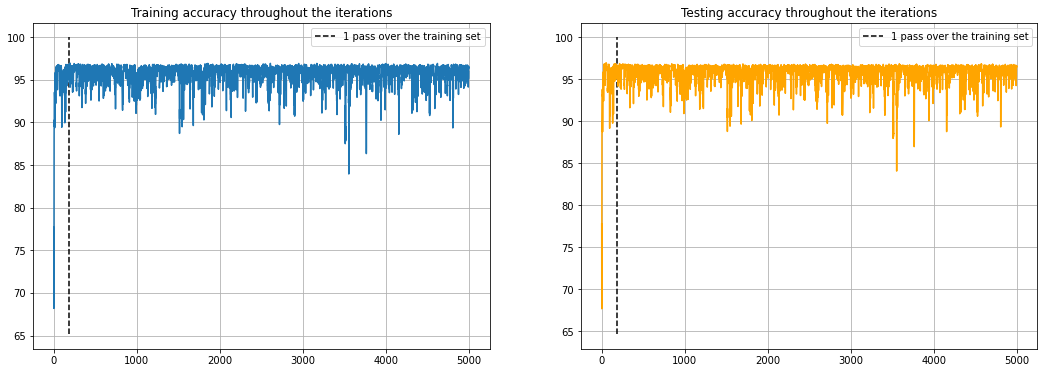

In [96]:
# get the training accuracy at each iteration 
accs_train = get_acc_iter(X_train, y_train, samples=samples)

# get the testing accuracy at each iteration 
accs_test = get_acc_iter(X_test, y_test, samples=samples)

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6))
num_epoch = 1
num_samples = X.shape[0]

# plot training accuracy throughout the iterations
ax[0].vlines(num_epoch*num_samples/batch_size, ymin=accs_train.min()-3, ymax=accs_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[0].plot(accs_train)
ax[0].set_title("Training accuracy throughout the iterations")
ax[0].legend()
ax[0].grid()

# plot testing accuracy throughout the iterations
ax[1].vlines(num_epoch*num_samples/batch_size, ymin=accs_test.min()-3, ymax=accs_train.max()+3, ls='--', color='k', label=f'{num_epoch} pass over the training set')
ax[1].plot(accs_test, c='orange')
ax[1].set_title("Testing accuracy throughout the iterations")
ax[1].legend()
ax[1].grid()

plt.show()

In [97]:
# get predictive distribution for each testing examples
pred_test = predictive_MC(X_new=X_test, samples=samples, burn_in=burn_in, weights=trackW)

# get a hard prediction
y_pred = 2 * (pred_test >= .5) -1

# get misclassified examples
idxs_misclass = np.where(y_pred != y_test)[0]

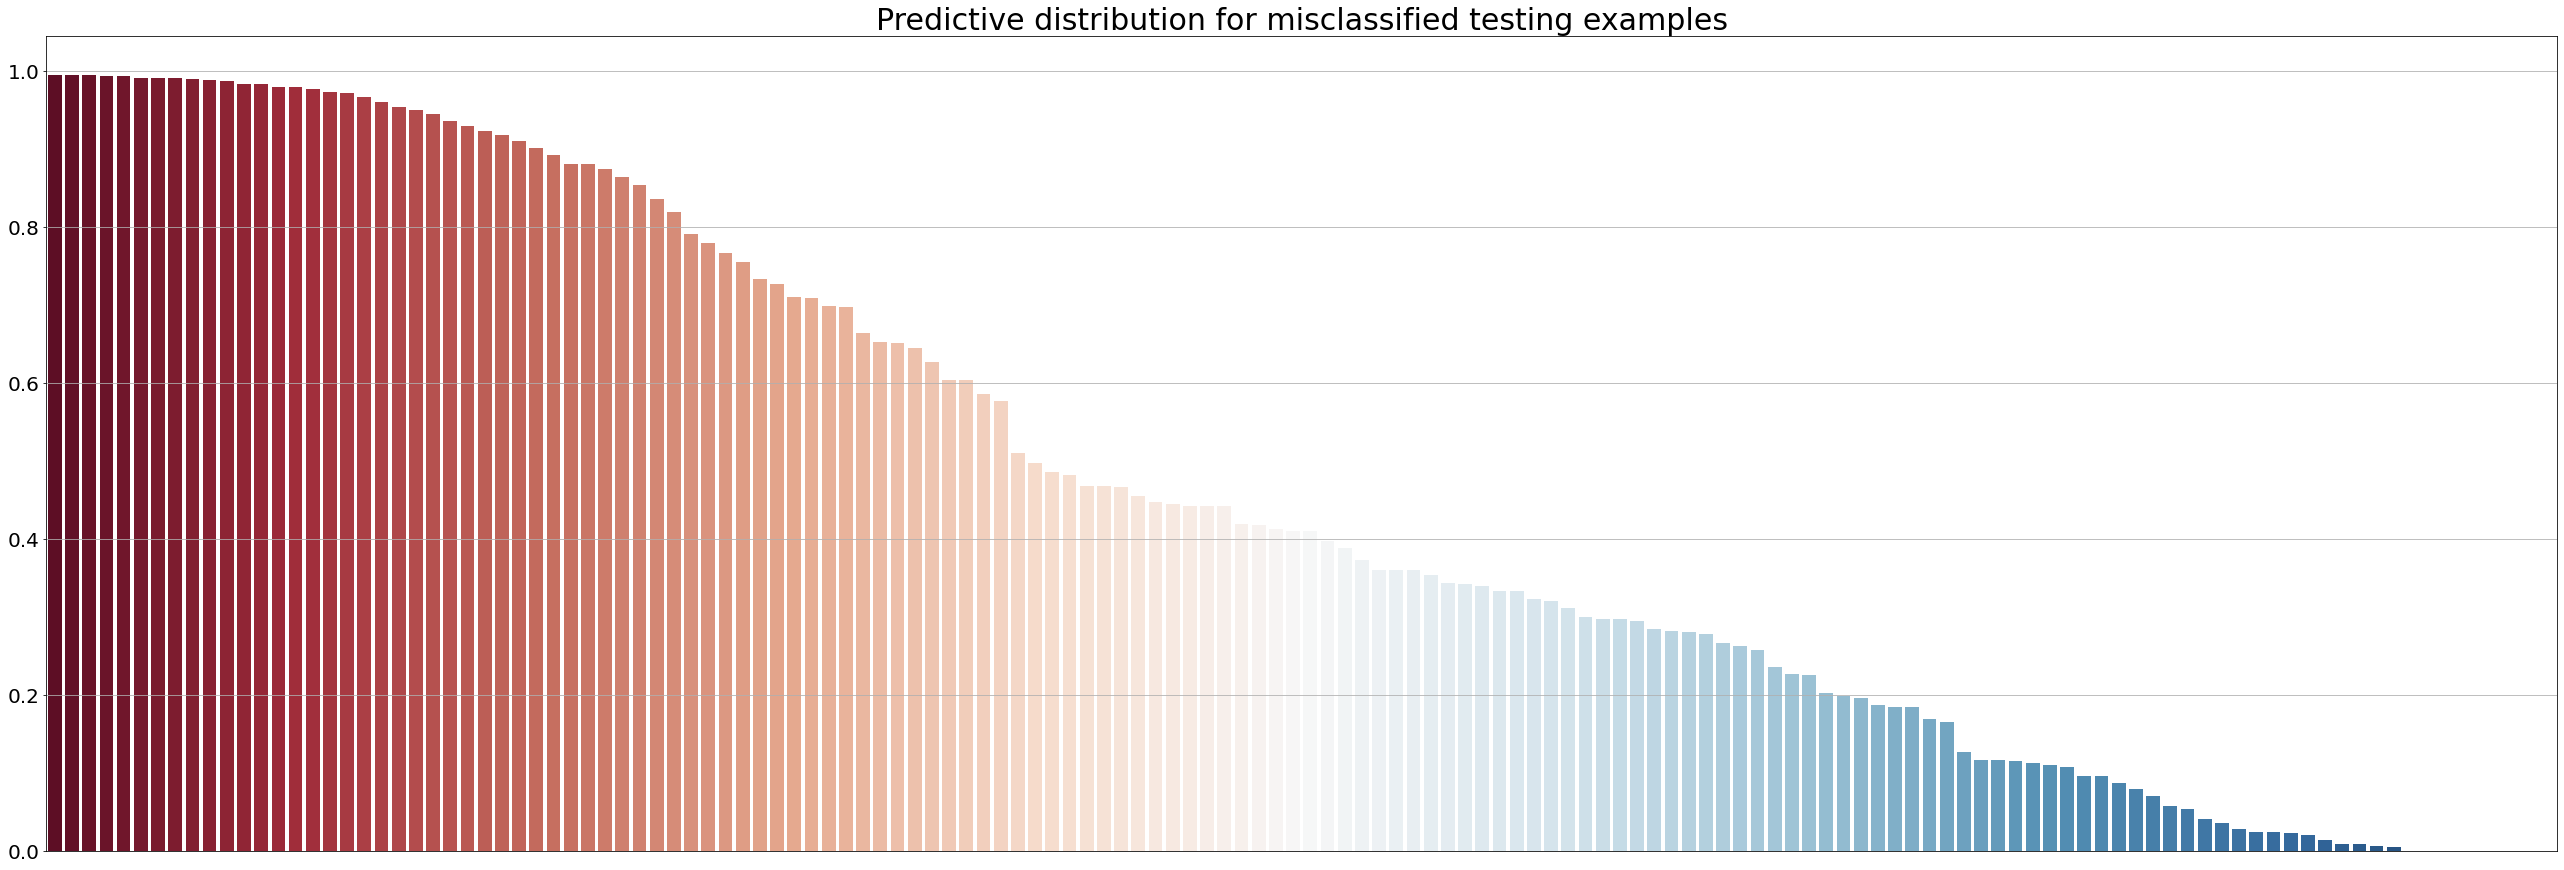

In [98]:
fig, ax = plt.subplots(figsize=(45,15))
bar = sns.barplot(y=np.flip(np.sort(pred_test[idxs_misclass])), 
            x=[str(x) for x in idxs_misclass[np.flip(np.argsort(pred_test[idxs_misclass]))]], 
            palette='RdBu', orient='v', ax=ax);
ax.axes.xaxis.set_ticks([])
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_title("Predictive distribution for misclassified testing examples", fontsize=30)
ax.grid();

In [99]:
# get robusteness criterion 
crit = get_criterion_ent(pred_distrib=pred_test, idxs_misclass=idxs_misclass)
print(f"Robustness criterion: {round(crit, 5)}.")

Robustness criterion: 0.57552.


Comme pour le data set précédent, nous observons des variations relativement importantes tout au long de la phase d'échantillonnage. La précision est un peu moins bonne qu'avec les méthodes précédentes (les paramètres pourraient sûrement être encore optimisés ici). 

Nous notons une **robustesse souvent plus élevée que dans les cas précédents**. Ceci est un argument en faveur d'une méthode Hamiltonienne plutôt que de celle de Langevin: la **dynamique étant simulée sur plus d'étapes, nous avons des chances de produire des échantillons relativement éloignés dans le champs de la posterior** et donc d'avoir plus d'information pour classifier une diversité de points ici. Nous payons tout de même le prix du temps de calcul encore ici.